# Import Libraries

In [1594]:
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
import shapefile as shp
import geopandas as gpd
from sklearn.svm import SVR
from sklearn import preprocessing
from sklearn.tree import DecisionTreeRegressor
from sklearn.decomposition import PCA
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression,Lasso
from matplotlib import rc
from sklearn.model_selection import train_test_split,GridSearchCV
from pandas.plotting import register_matplotlib_converters
import math
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor,ExtraTreesRegressor
from sklearn.metrics import mean_squared_error,mean_absolute_error , r2_score
from sklearn.preprocessing import MinMaxScaler

warnings.filterwarnings('ignore')

%matplotlib inline
%config InlineBackend.figure_format='retina'

register_matplotlib_converters()
sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 16, 6

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

Helper Functions

In [1096]:
def model_evaluate(name,type,model,transformer,x,y):
    
    y_pred = model.predict(x)
    
    y_inv = transformer.inverse_transform(y.reshape(1, -1)).flatten()

    y_pred_inv = transformer.inverse_transform(y_pred.reshape(1, -1)).flatten()
    
    rmse = math.sqrt(mean_squared_error(y_inv, y_pred_inv))
    mse = mean_squared_error(y_inv, y_pred_inv)
    r2 = r2_score(y_inv, y_pred_inv)
    
    return [name,type,rmse,mse,r2]

# Data Preperation

In [1596]:
df = pd.read_csv("restaurant dataset.csv")

In [1330]:
df.head()

,id,name,table_bookings,online_ordering,location,rating,votes,phone,restaurant_type,restaurant_operation,popular_dishes,cuisines_offered,primary_cuisine,Unnamed: 13
0,19281,Plan B,No,No,Greenwich,4.2/5,1651.0,8041609100,Casual Dining,Drinks & nightlife,7.0,4.0,American,NaN
1,16095,Mom's Kitchen,No,No,East Village,NaN,0.0,"9738732072, 9742716121",Delivery,Delivery,1.0,1.0,American,NaN
2,42040,Keys Cafe - Keys Hotel,No,No,Chinatown,2.8 /5,161.0,080 39451000\n 8884038484,Casual Dining,Dine-out,7.0,3.0,Chinese,NaN
3,18753,Smally's Resto Cafe,Yes,No,Greenwich,4.0/5,401.0,"080 48149349, 9632015858",Cafe,Dine-out,7.0,5.0,Snacks,NaN
4,21065,Fabcafe,No,Yes,Chelsea,3.8 /5,11.0,8050403072,Cafe,Dine-out,1.0,2.0,Snacks,NaN


In [663]:
df.shape

(3484, 14)

In [668]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3484 entries, 0 to 3483
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    3484 non-null   int64  
 1   name                  3484 non-null   object 
 2   table_bookings        3484 non-null   object 
 3   online_ordering       3484 non-null   object 
 4   location              3484 non-null   object 
 5   rating                2960 non-null   object 
 6   votes                 3418 non-null   float64
 7   phone                 3435 non-null   object 
 8   restaurant_type       3342 non-null   object 
 9   restaurant_operation  3456 non-null   object 
 10  popular_dishes        3312 non-null   float64
 11  cuisines_offered      3456 non-null   float64
 12  primary_cuisine       3456 non-null   object 
 13  Unnamed: 13           2435 non-null   float64
dtypes: float64(4), int64(1), object(9)
memory usage: 381.2+ KB


In [1597]:
df.drop(columns=['phone','Unnamed: 13'],inplace=True)

In [670]:
# Verify Value consistency
for col in df.select_dtypes('object'):
    if len(df[col].unique()) > 100:
        print(col, ":", len(df[col].unique()), "\n")
    else:
        print(col, ":", df[col].unique(), "\n")

name : 1101 

table_bookings : ['No' 'Yes'] 

online_ordering : ['No' 'Yes'] 

location : ['Greenwich' 'East Village' 'Chinatown' 'Chelsea' 'Tribeca'
 'Staten and Ellis Islands' 'Lower Manhattan' 'Midtown'] 

rating : ['4.2/5' nan '2.8 /5' '4.0/5' '3.8 /5' '4.5 /5' '3.7 /5' '3.9 /5' '4.4 /5'
 '4.1/5' '3.7/5' '4.1 /5' '3.5/5' 'NEW' '4.4/5' '3.2 /5' '3.4 /5' '2.9/5'
 '3.5 /5' '3.9/5' '3.1 /5' '3.3 /5' '3.6/5' '4.5/5' '2.6 /5' '4.2 /5'
 '4.0 /5' '3.2/5' '2.7 /5' '3.8/5' '4.3/5' '4.3 /5' '4.7 /5' '2.8/5'
 '3.1/5' '3.6 /5' '2.4 /5' '3.4/5' '3.0/5' '2.9 /5' '2.6/5' '2.7/5'
 '3.0 /5' '3.3/5' '4.7/5' '2.5/5' '4.6 /5' '4.6/5' '4.8 /5' '2.5 /5'
 '4.8/5' '-' '2.2/5' '2.1 /5' '2.4/5'] 

restaurant_type : ['Casual Dining' 'Delivery' 'Cafe' 'Quick Bites' 'Takeaway' nan 'Bar'
 'Lounge' 'Mess' 'Fine Dining' 'Pub' 'Microbrewery' 'Food Court' 'Dhaba'] 

restaurant_operation : ['Drinks & nightlife' 'Delivery' 'Dine-out' 'Buffet' 'Cafes' 'Desserts'
 'Pubs and bars' nan] 

primary_cuisine : ['American' 'Ch

In [1598]:
df[df['rating'].isin(['NEW','-'])].votes.value_counts()

0.0    177
Name: votes, dtype: int64

In [1599]:
df['rating'].replace('NEW','0',inplace=True)
df['rating'].replace('-','0',inplace=True)

In [1600]:
notnull_ratings = df.dropna(subset=['rating'])
notnull_ratings['rating'] = notnull_ratings['rating'].apply(lambda x: float(x.split('/')[0]))
df = pd.merge(left=notnull_ratings,right=df,on=df.drop(columns=['rating']).columns.tolist(),how='outer',suffixes=('', '_drop'))
df.drop([col for col in df.columns if 'drop' in col], axis=1, inplace=True)
df.drop(columns=['id'],inplace=True)

In [1601]:
print(df['rating'].sort_values().unique())

[0.  2.1 2.2 2.4 2.5 2.6 2.7 2.8 2.9 3.  3.1 3.2 3.3 3.4 3.5 3.6 3.7 3.8
 3.9 4.  4.1 4.2 4.3 4.4 4.5 4.6 4.7 4.8 nan]


In [1602]:
duplicate = df[df.duplicated()]
df.drop_duplicates(inplace=True, keep='first')
df = df.reset_index(drop=True)

In [1603]:
df = df[df['rating'] > 0 ]

In [1604]:
df[(df['votes'] == 0) & (df['rating'] > 0)].votes.value_counts()

0.0    5
Name: votes, dtype: int64

In [1605]:
df = df[~((df['votes'] == 0) & (df['rating'] > 0))]

In [1606]:
df.describe()

,rating,votes,popular_dishes,cuisines_offered
count,2319.000000,2264.000000,2181.000000,2300.000000
mean,3.798663,644.937721,4.322788,2.713043
std,0.452596,1453.343317,2.787320,1.388546
min,2.100000,4.000000,1.000000,1.000000
25%,3.500000,36.000000,1.000000,2.000000
50%,3.900000,142.000000,6.000000,3.000000
75%,4.100000,632.000000,7.000000,4.000000
max,4.800000,14723.000000,7.000000,8.000000


# Data visualization

what is the frequency of restaurants locations ?

Text(0.5, 1.02, 'Locations Frequency')

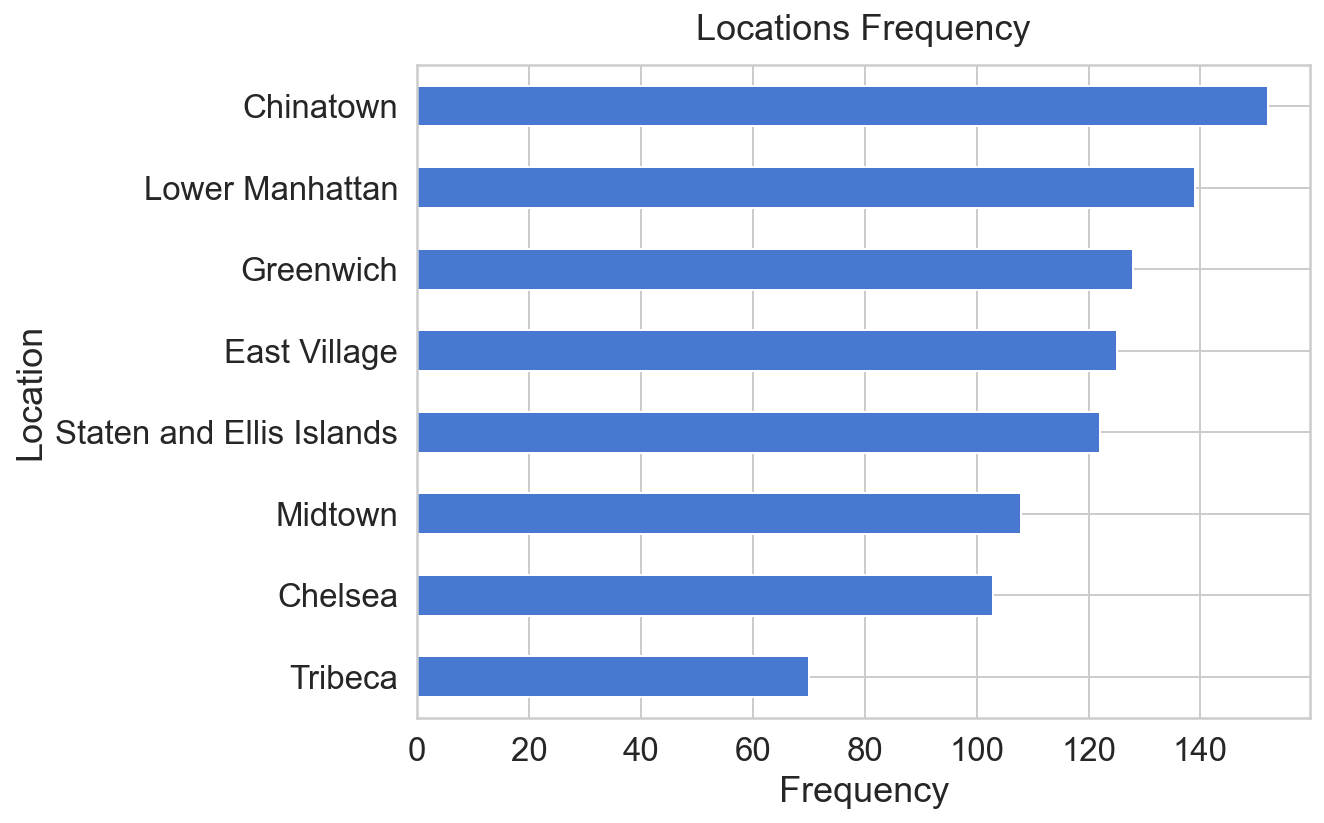

In [1627]:
df_restaurant_locations_freq = df.groupby('location').agg(frequency=("name",pd.Series.nunique),rating=('rating','mean')).sort_values(by='frequency',ascending=False)
df_restaurant_locations_freq[['frequency']].sort_values(by='frequency',ascending=True).plot(kind='barh',figsize=(8, 6))
plt.xlabel("Frequency")
plt.ylabel("Location")
legend = plt.legend()
legend.remove()
plt.title("Locations Frequency", y=1.02)

How does locations correlates with ratings ?

Text(0.5, 1.0, 'Location Average Ratings')

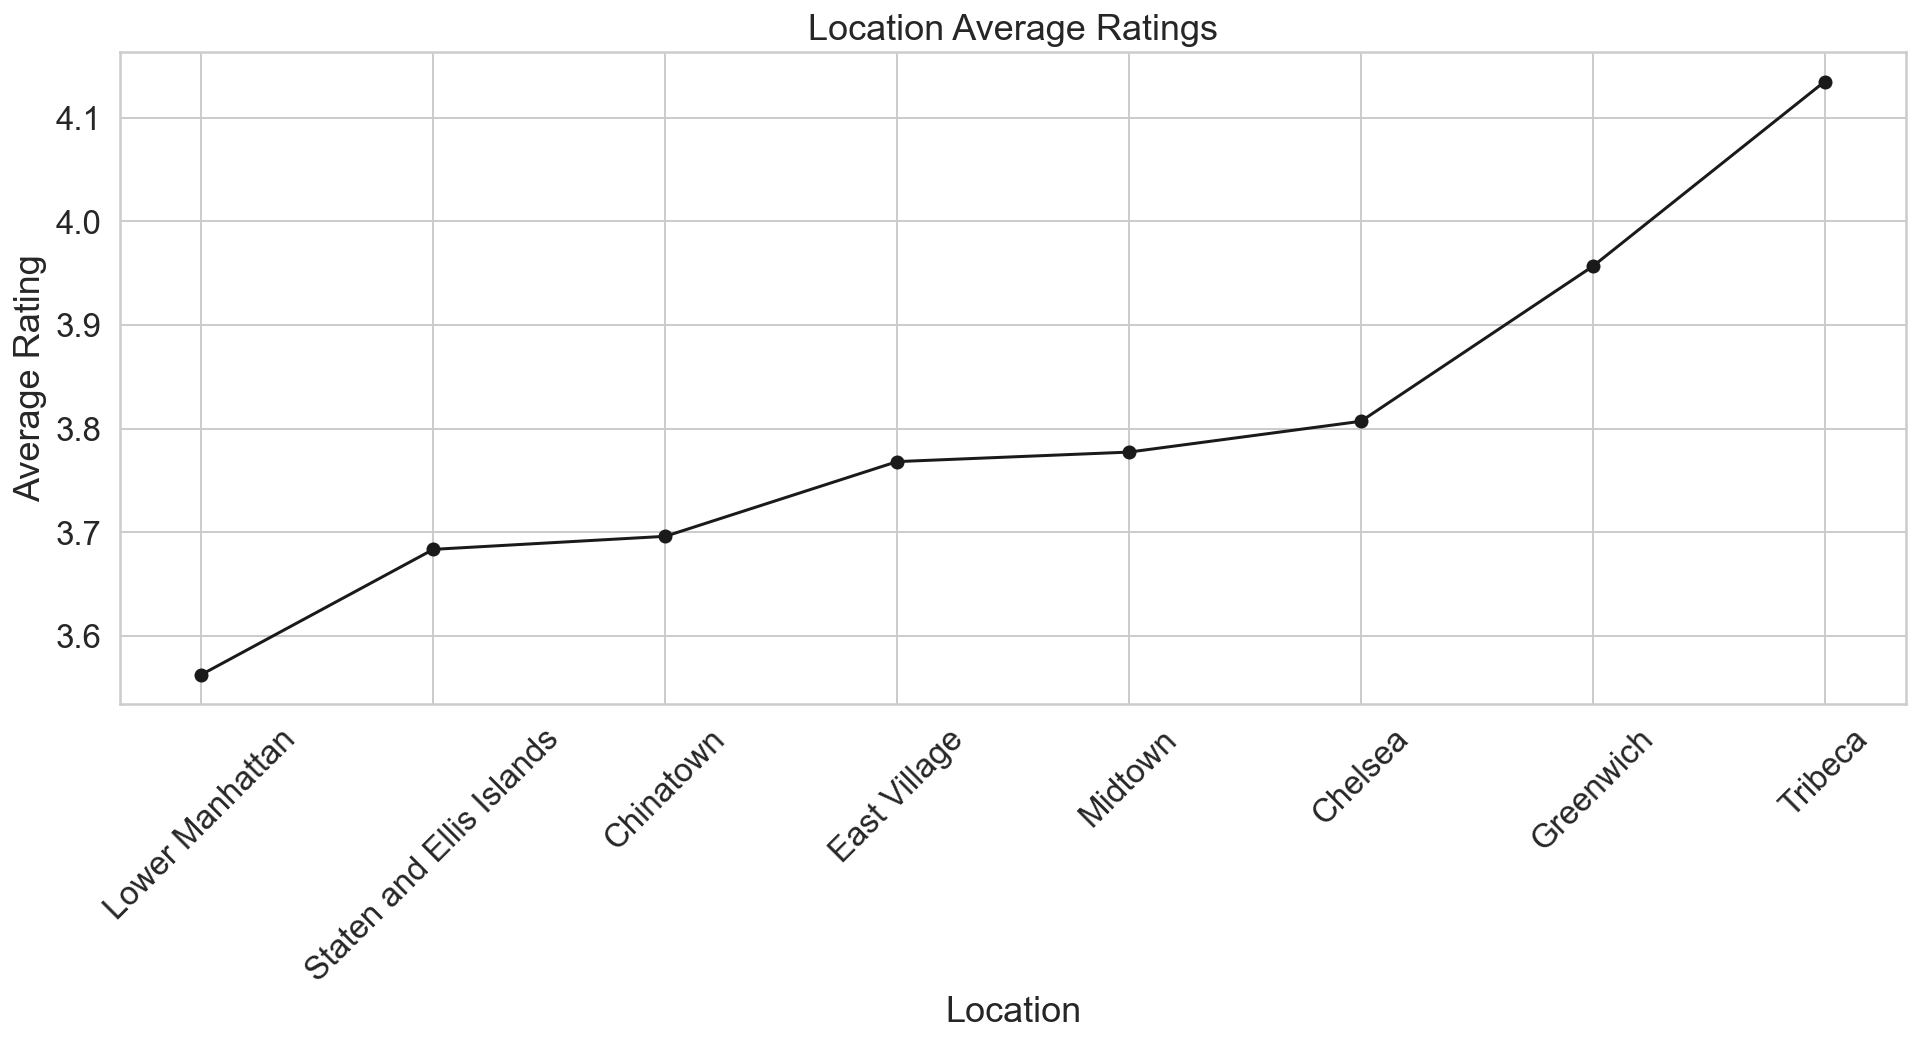

In [1628]:
location_average_ratings = df.groupby('location').agg({'rating':'mean'}).sort_values(by='rating',ascending=True)
plt.plot(location_average_ratings.index,location_average_ratings['rating'],'ko-',label='rating')
plt.xticks(rotation=45)
plt.xlabel("Location")
plt.ylabel("Average Rating")
plt.title("Location Average Ratings")

- Tribeca and Greenwich tends to have a slight better ratings than other locations
- locations have a little incorporation with predicting ratings

Which restaurants has the hightest number of different stores locations ?

Text(0.5, 1.02, 'Most Scattered Restaurants')

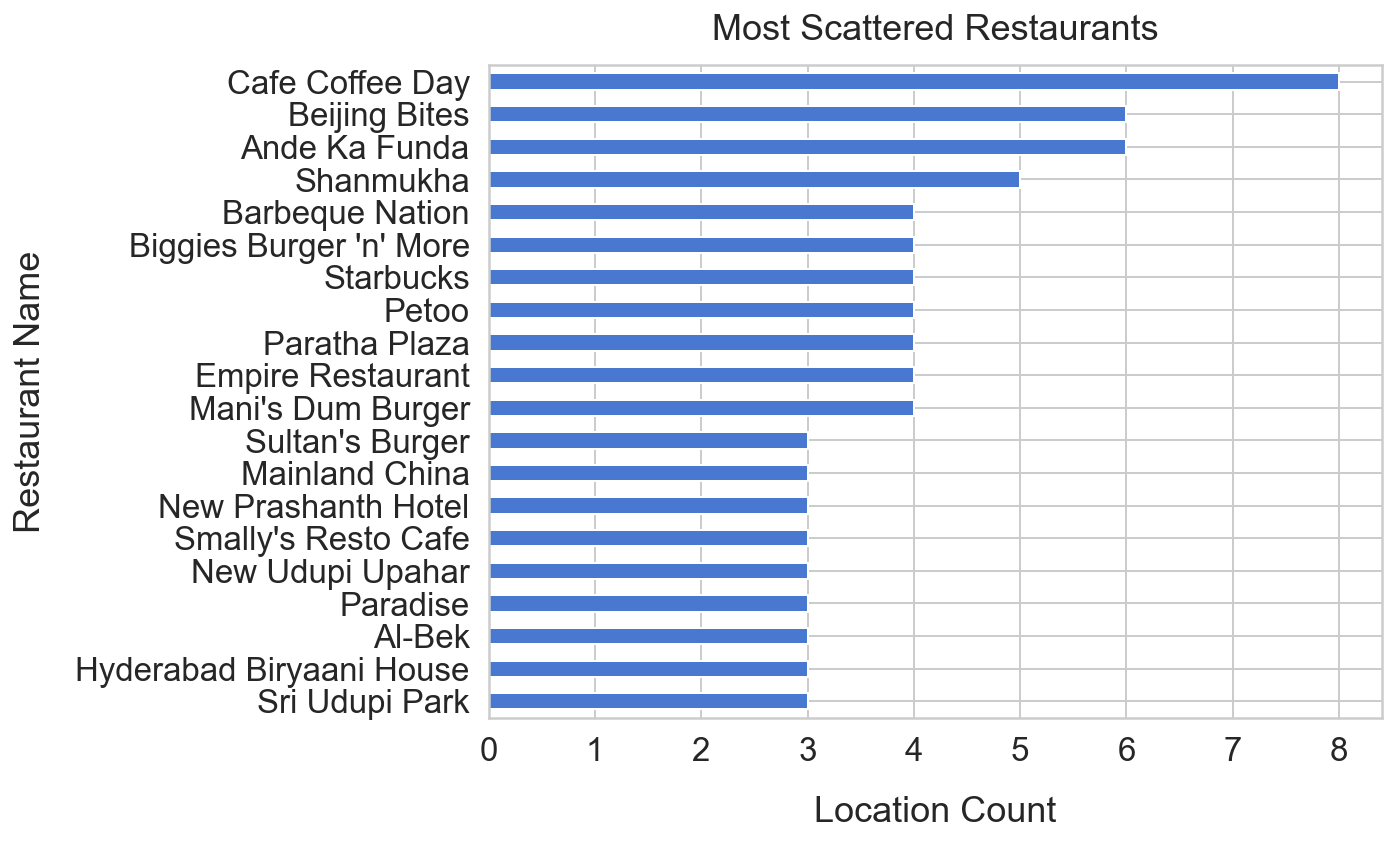

In [1629]:
limit = 20
df_top_frequenced_locations = df.groupby('name').agg(frequency=(
    "location", pd.Series.nunique)).sort_values(by='frequency', ascending=False).head(limit)
df_top_frequenced_locations.sort_values(
    by='frequency', ascending=True).plot(kind='barh', figsize=(8, 6))
plt.xlabel("Location Count", labelpad=14)
plt.ylabel("Restaurant Name", labelpad=14)
legend = plt.legend()
legend.remove()
plt.xticks(range(0, df_top_frequenced_locations.frequency.max()+1))
plt.title("Most Scattered Restaurants", y=1.02)


Does Having more than one store location correlate with higher ratings ?

In [1630]:
df_top_frequenced_restaurants_locations = df.groupby('name').agg(location_frequency=("location",pd.Series.nunique),average_rating=('rating','median'),total_votes=('votes','median'))
corr = df_top_frequenced_restaurants_locations.corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

,location_frequency,average_rating,total_votes
location_frequency,1.00,0.07,0.14
average_rating,0.07,1.00,0.47
total_votes,0.14,0.47,1.00


What is the distribution of Table-Bookings ?

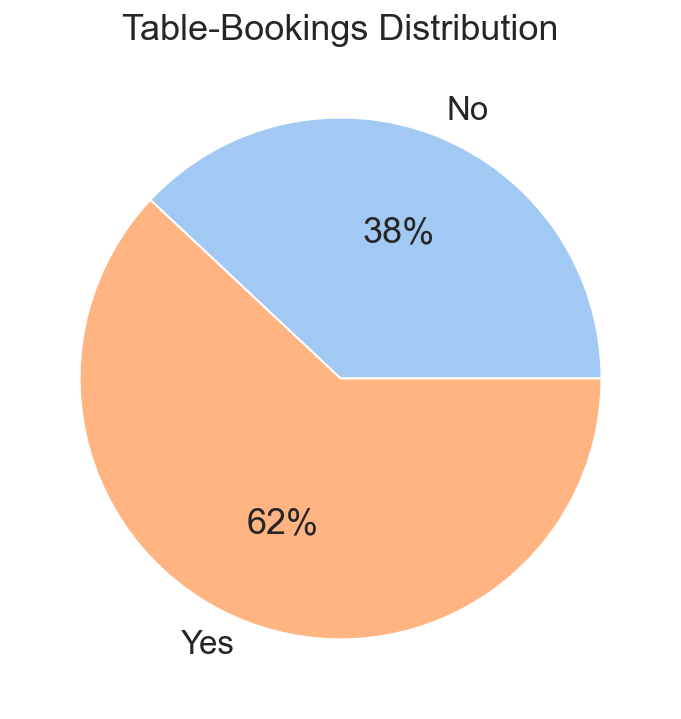

In [715]:
data = df.groupby('table_bookings')['table_bookings'].count()
labels = df.groupby('table_bookings')['table_bookings'].count().index

colors = sns.color_palette('pastel')[0:5]

plt.pie(data, labels = labels, colors = colors, autopct='%.0f%%')
plt.title('Table-Bookings Distribution')
plt.show()

- Most of the restaurants have table-bookings option with 62%

How does the distribution of table-bookings correlates with ratings ?

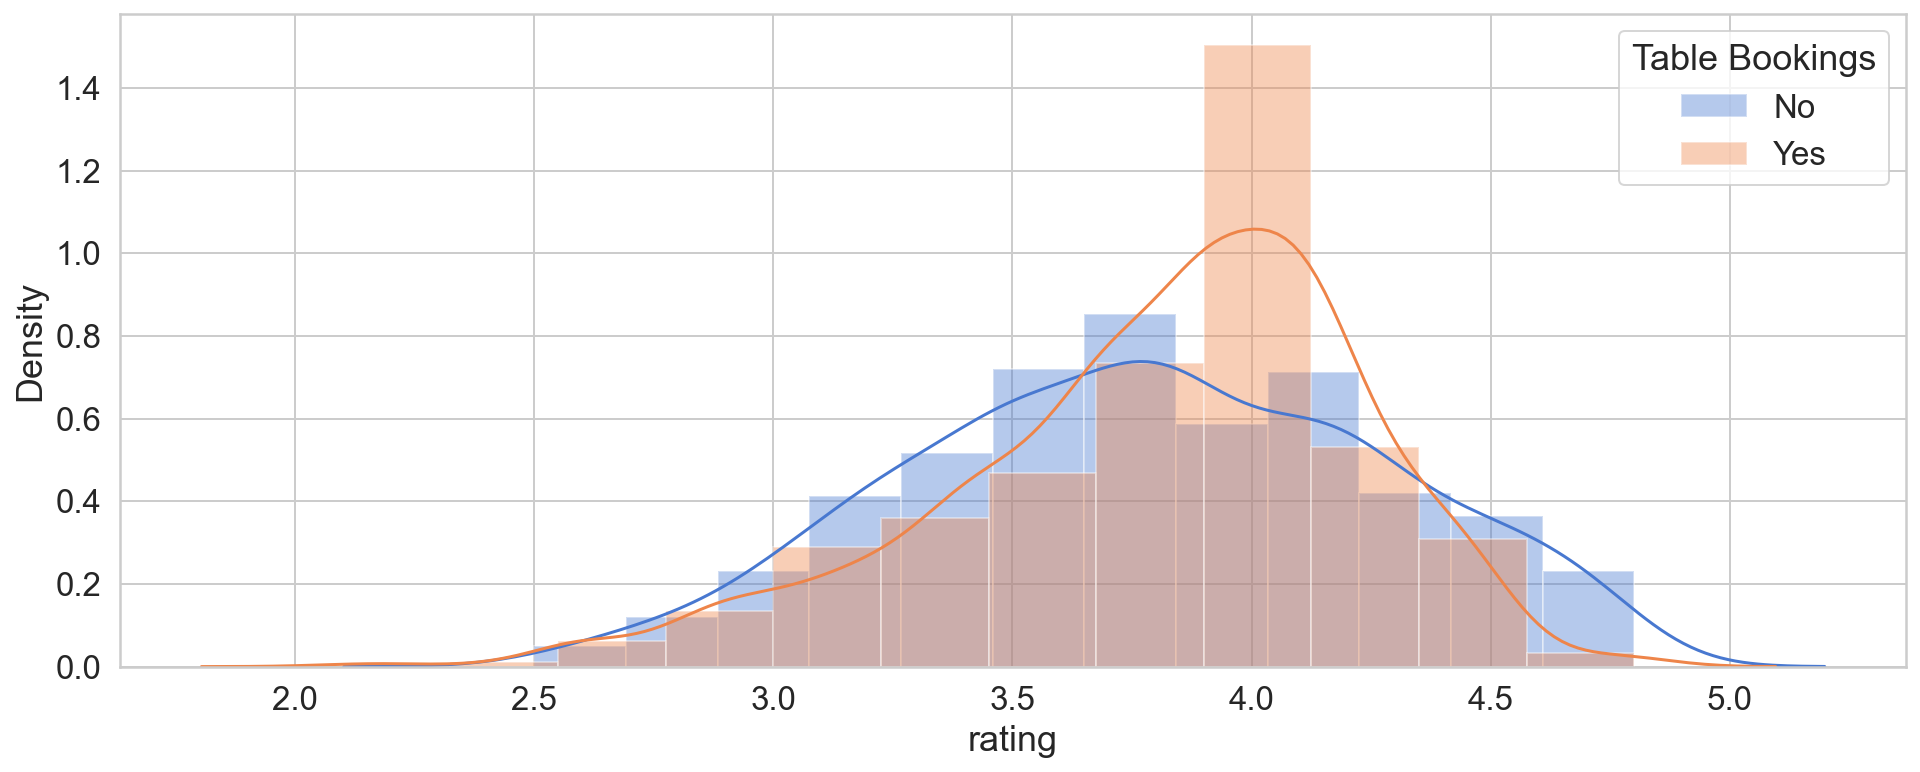

In [1449]:
for val in df['table_bookings'].unique():
    sns.distplot(df[df['table_bookings'] == val]
                    ['rating'], hist=True, label=val,bins=12)
    plt.legend(title="Table Bookings")

- Restaurant with table-bookings has a slight higher ratings than non-table-booking restaurants

What is the distribution of Online-Ordering Column ?

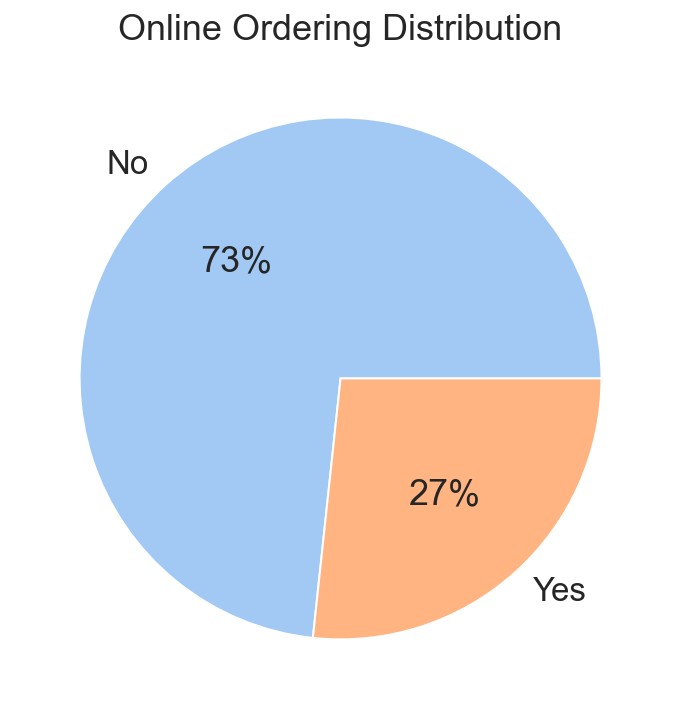

In [1451]:
data = df.groupby('online_ordering')['online_ordering'].count()
labels = df.groupby('online_ordering')['online_ordering'].count().index

colors = sns.color_palette('pastel')[0:5]

plt.pie(data, labels = labels, colors = colors, autopct='%.0f%%')
plt.title('Online Ordering Distribution')
plt.show()

- Most of the restaurants doesn't have online-ordering option with 73%

How does the distribution of online-ordering correlates with ratings ?

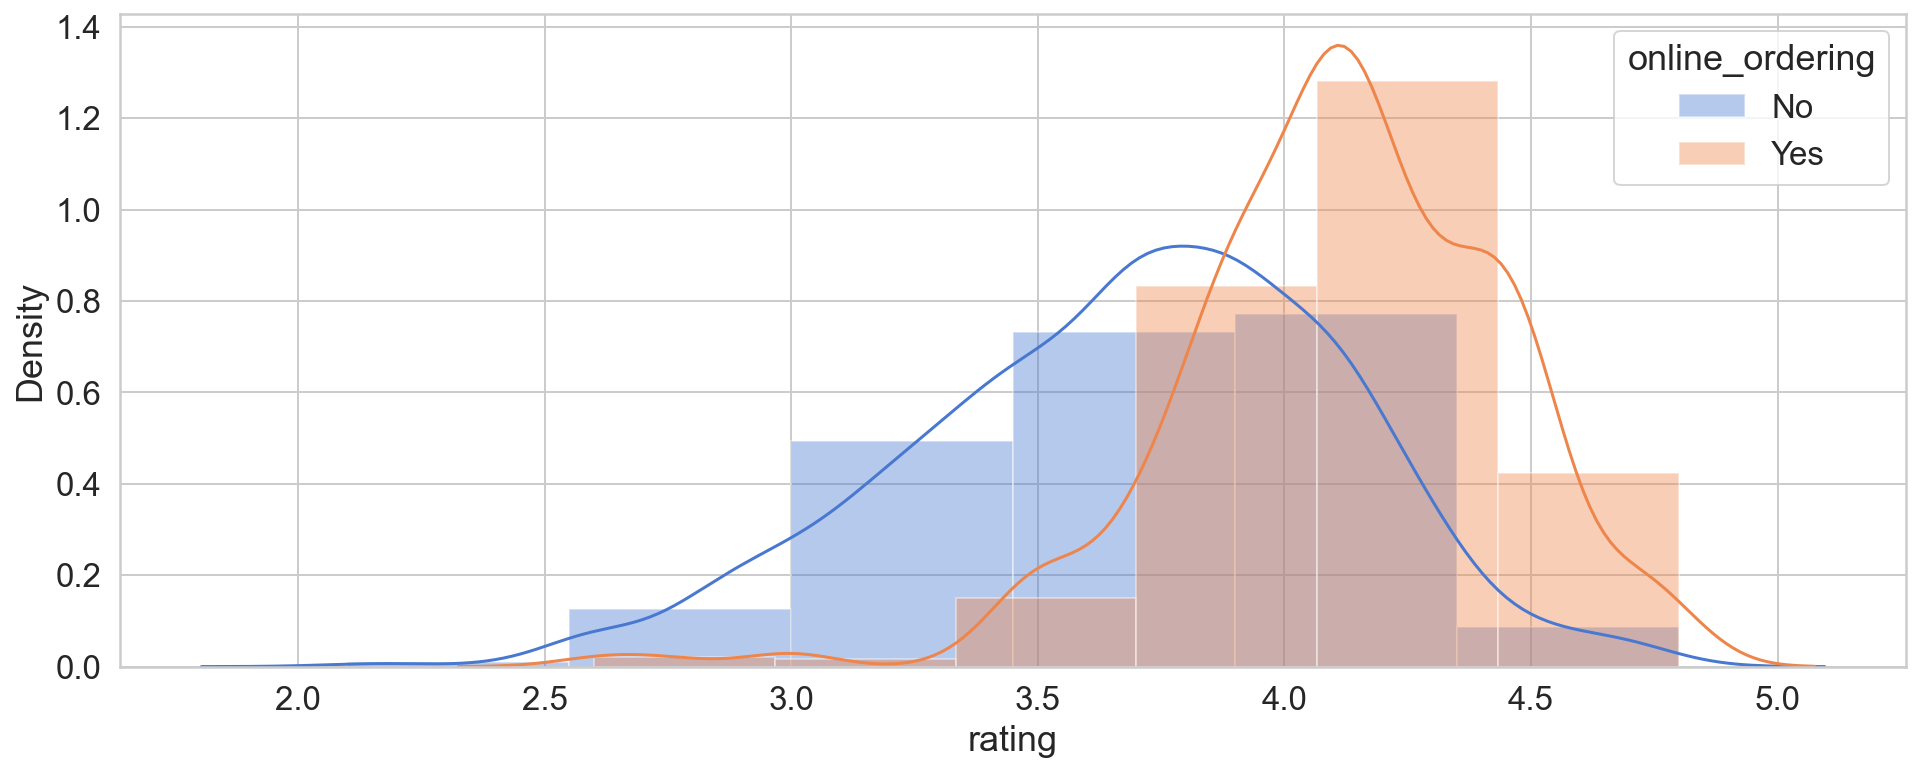

In [1438]:
for val in df['online_ordering'].unique():
    sns.distplot(df[df['online_ordering'] == val]
                    ['rating'], hist=True, label=val,bins=6)
    plt.legend(title="online_ordering")

- online-ordering restaurants tend to have higher ratings rather than offline-ordering restaurants
- restaurants that doesn't have online ordering may need to enable this features because it increases the customer statisfaction

How does the distribution of online-ordering correlates with ratings ?

Text(0.5, 1.02, 'Online Ordering Distribution over votes')

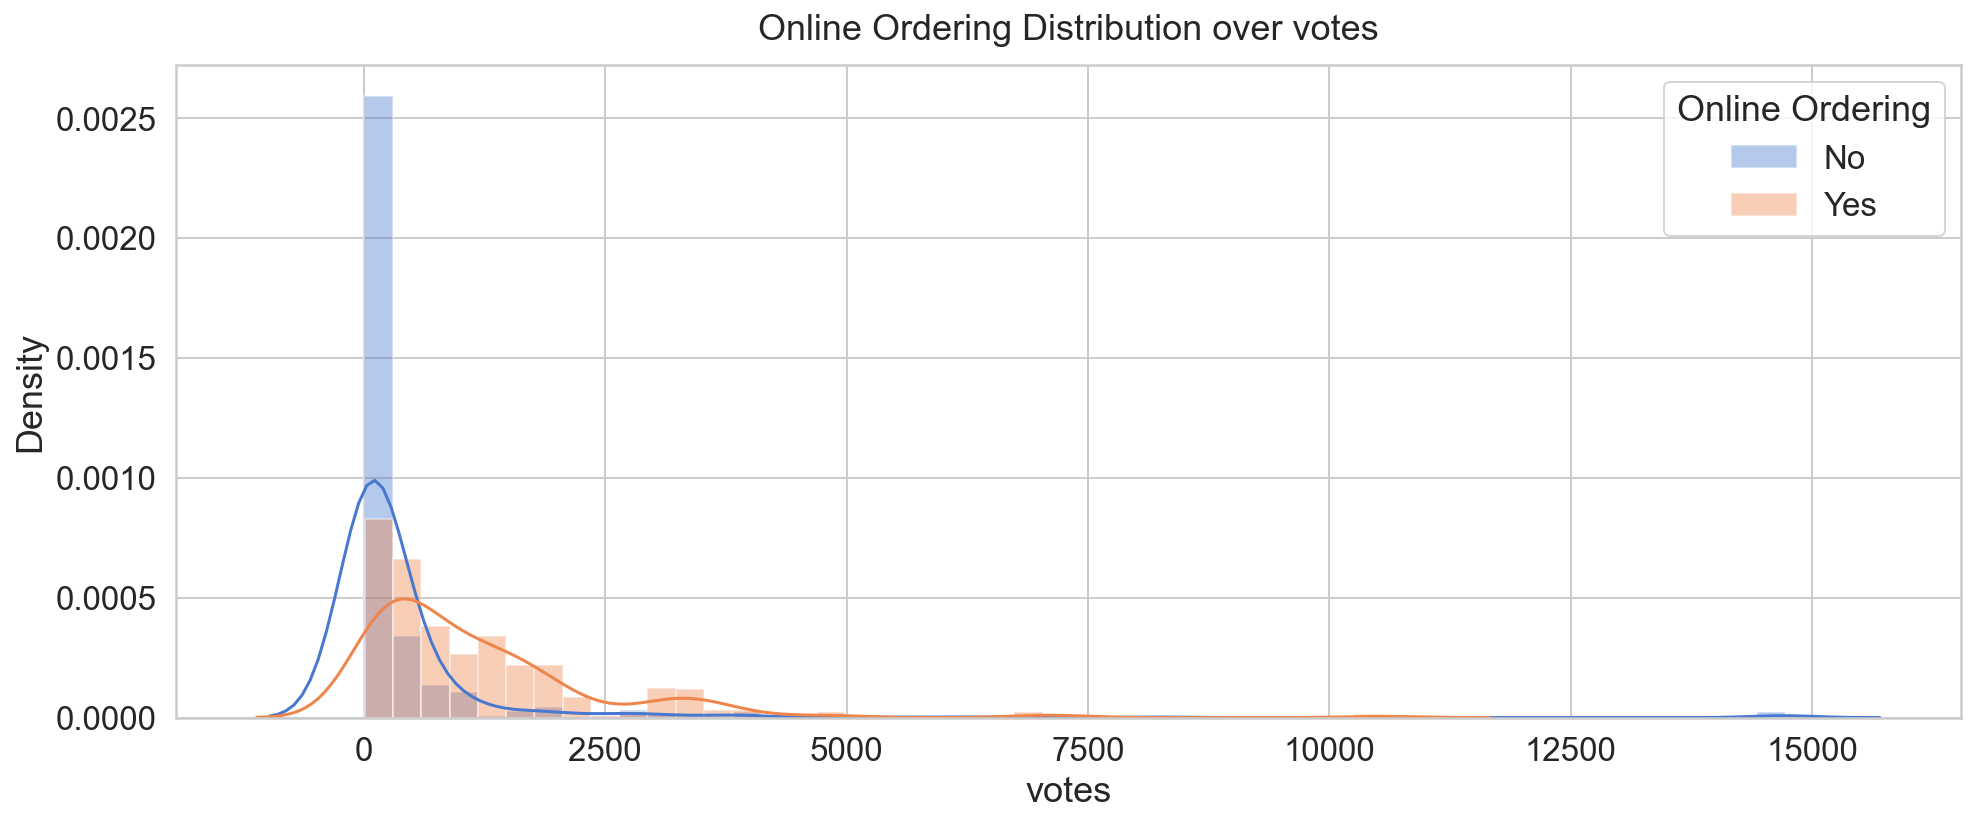

In [1562]:
for val in df['online_ordering'].unique():
    sns.distplot(df[df['online_ordering'] == val]
                    ['votes'], hist=True, label=val)
    plt.legend(title='Online Ordering')
plt.title("Online Ordering Distribution over votes",y=1.02)

- The reason why online ordering tends to have more votes than no-online ordering may be because of there is an application where people can vote easily
- restaurants that doesn't have online-ordering may need to enable this features because it would give them better vision about their service through getting more votes from more customers

What is the distribution of primary_cuisine Column ?

what is the most frequenced primary_cuisine ?

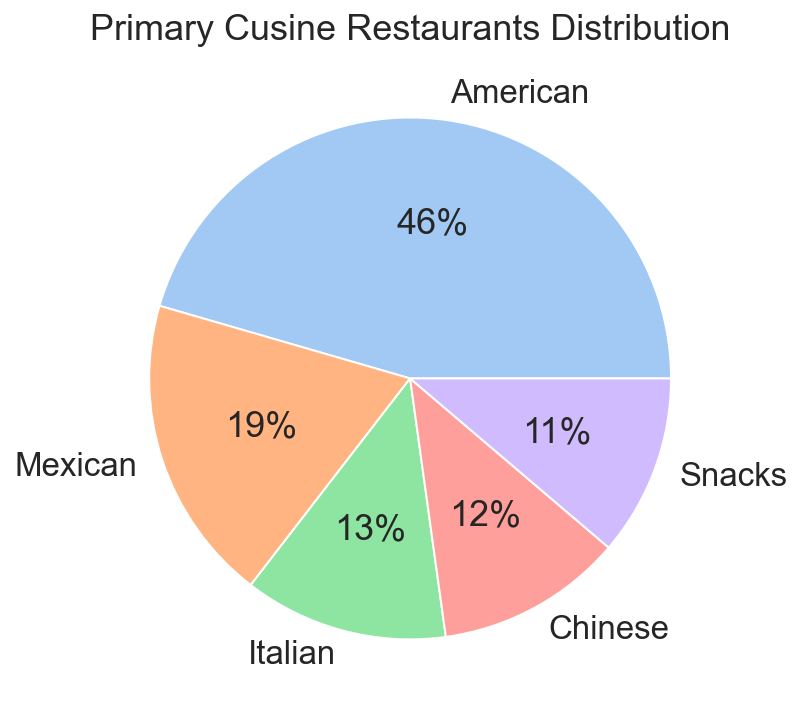

In [1578]:
df_top_frequenced_primary_cuisine = df.groupby(['primary_cuisine','name']).size().reset_index().groupby('primary_cuisine').size().reset_index(name='counts').sort_values(by='counts',ascending=False).reset_index()
data = df_top_frequenced_primary_cuisine.counts.values
labels = df_top_frequenced_primary_cuisine.primary_cuisine.values

colors = sns.color_palette('pastel')[0:5]

plt.pie(data, labels = labels, colors = colors, autopct='%.0f%%')
plt.title('Primary Cusine Restaurants Distribution')
plt.show()

- American Cuisine is the dominant primary_cuisine with a percentage of 46%
- American and Mexican Cuisine is the dominant primary_cuisine with a percentage of 65%
- Snacks Cuisine is the least frequenced primary_cuisine with a percentage of 11%

How does the distribution of primary_cuisine correlates with ratings ?

Text(0.5, 1.02, 'Primary Cuisine Distribution over ratings')

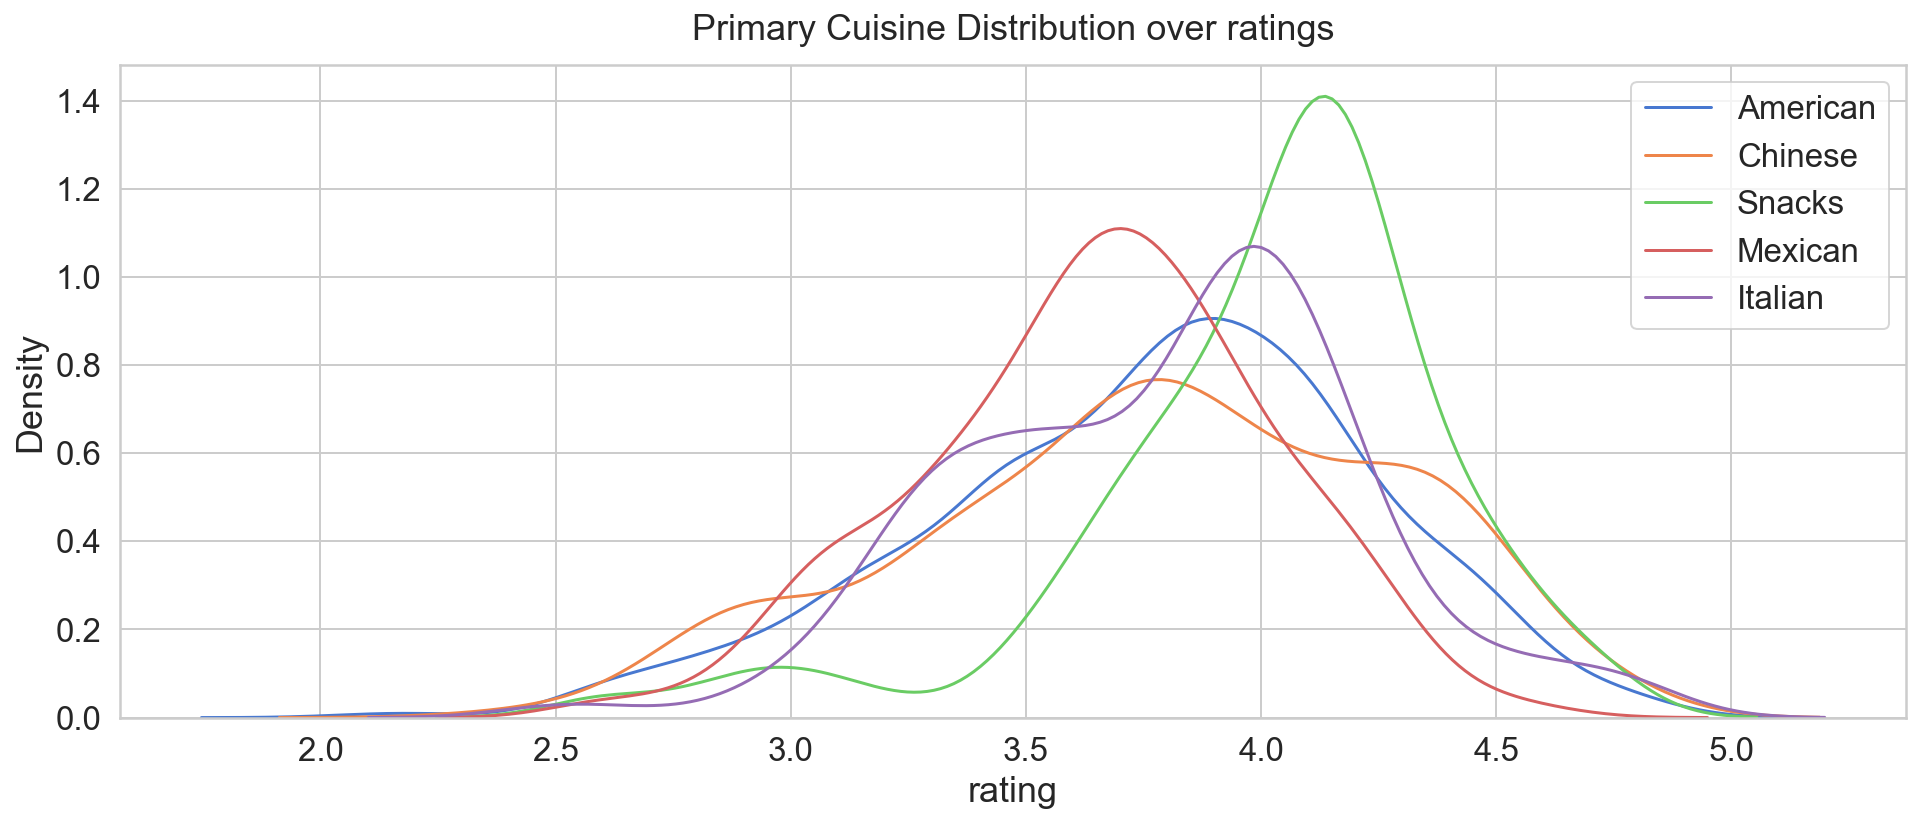

In [1579]:
for val in df['primary_cuisine'].unique():
    sns.distplot(df[df['primary_cuisine'] == val]
                    ['rating'], hist=False, label=val)
    plt.legend()
plt.title("Primary Cuisine Distribution over ratings",y=1.02)

- snacks restaurants have the hightest ratings
- Mexican restaurants have the lowest ratings
- primary cuisine column tends to correlate with ratings

What is the distribution of restaurant_type Column ?

Text(0.5, 1.02, 'Restaurants Types Frequency')

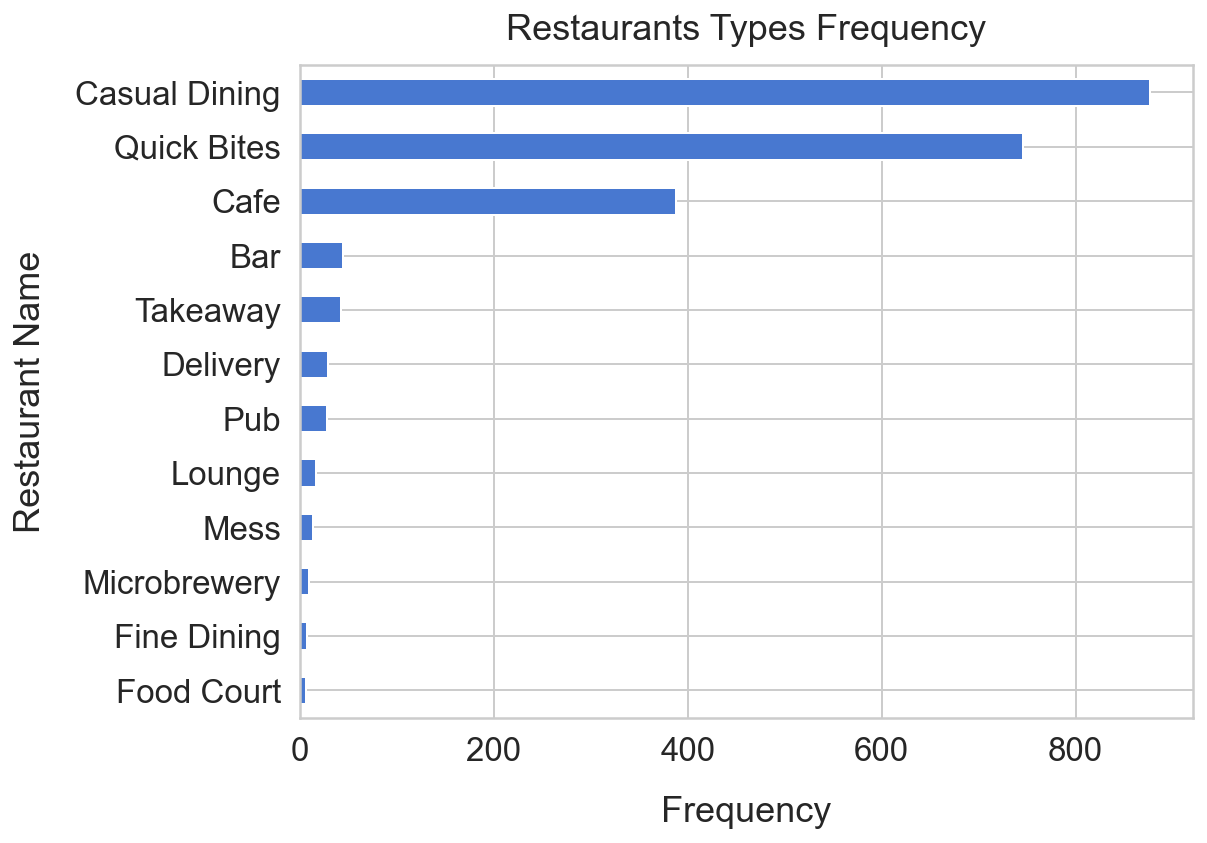

In [1580]:
df_top_frequenced_restaurants_types = df.groupby('restaurant_type').agg(frequency=("table_bookings",'count')).sort_values(by='frequency',ascending=False)
df_top_frequenced_restaurants_types.sort_values(by='frequency',ascending=True).plot(kind='barh',figsize=(8, 6))
plt.xlabel("Frequency", labelpad=14)
legend = plt.legend()
legend.remove()
plt.ylabel("Restaurant Name", labelpad=14)
plt.title("Restaurants Types Frequency", y=1.02)

- Quick Bites, Casual Dining and Cafe have the majority restaurant types

How does the distribution of restaurant_type correlates with ratings ?

Text(0.5, 1.0, 'Restaurant-types Average Ratings')

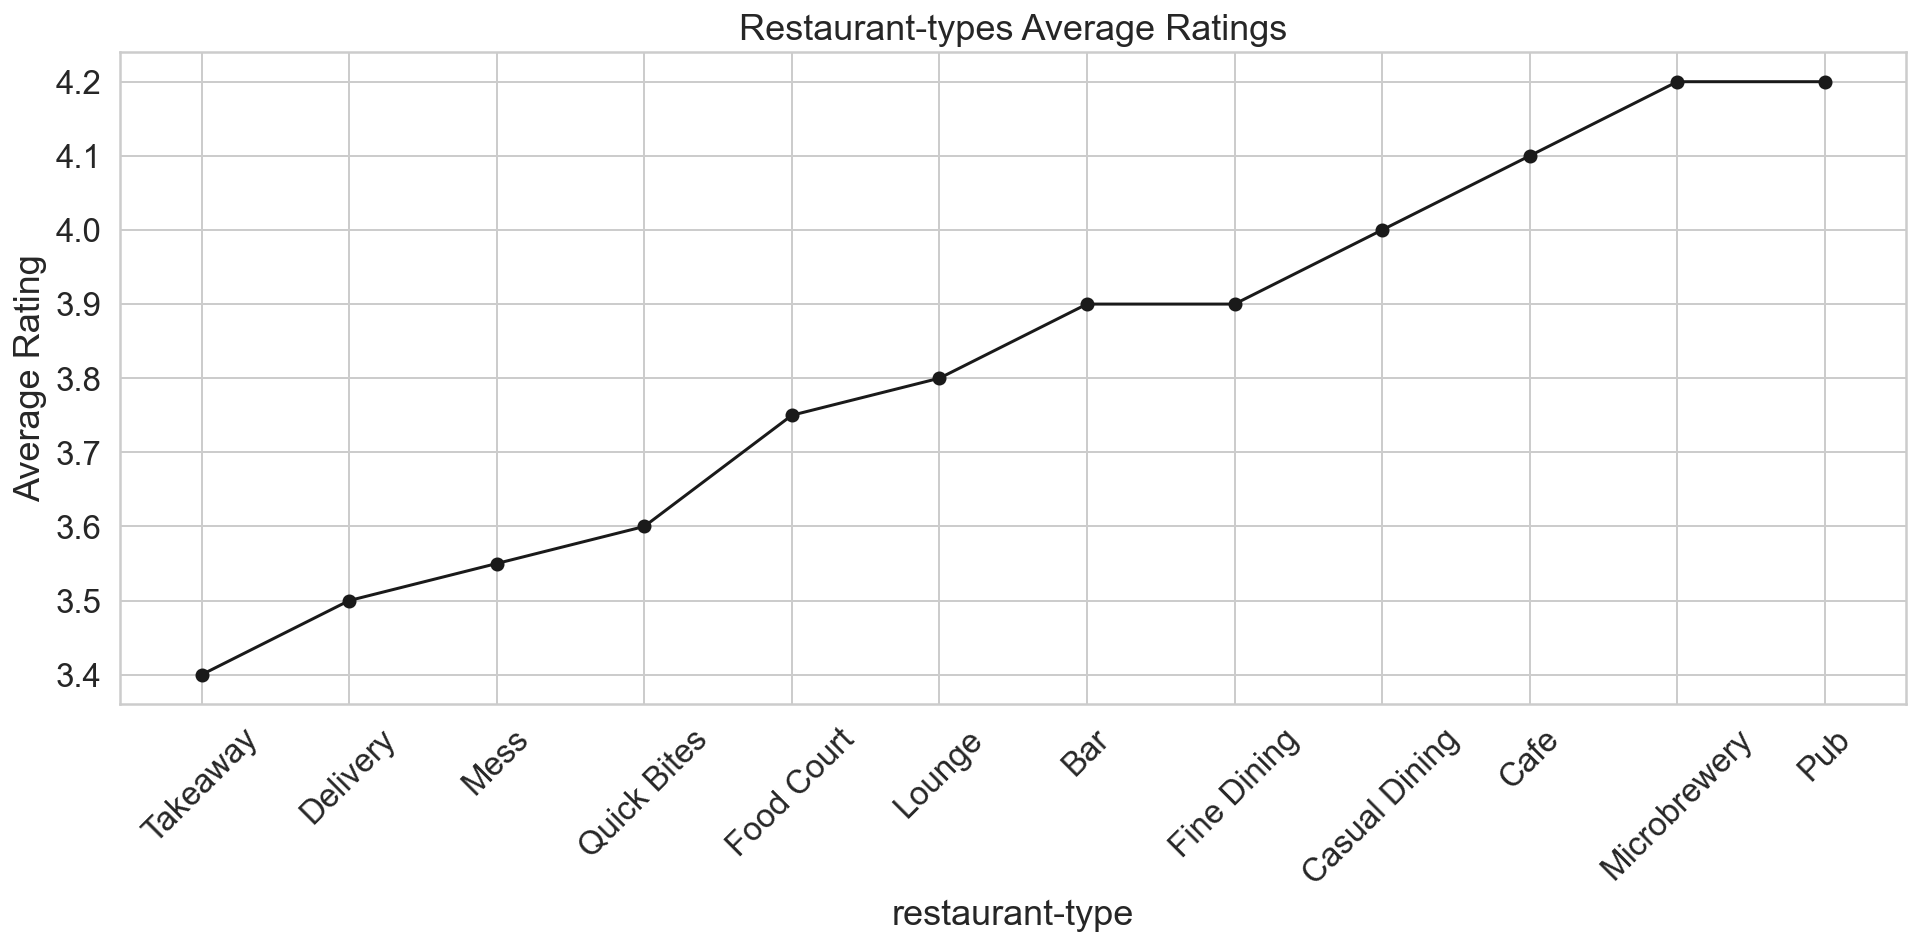

In [1581]:
location_average_ratings = df.groupby('restaurant_type').agg({'rating':'median'}).sort_values(by='rating',ascending=True)
plt.plot(location_average_ratings.index,location_average_ratings['rating'],'ko-',label='rating')
plt.xticks(rotation=45)
plt.xlabel("restaurant-type")
plt.ylabel("Average Rating")
plt.title("Restaurant-types Average Ratings")

What is the distribution of Restaurants-opertation ?

Text(0.5, 1.02, 'Restaurants Operation Frequency')

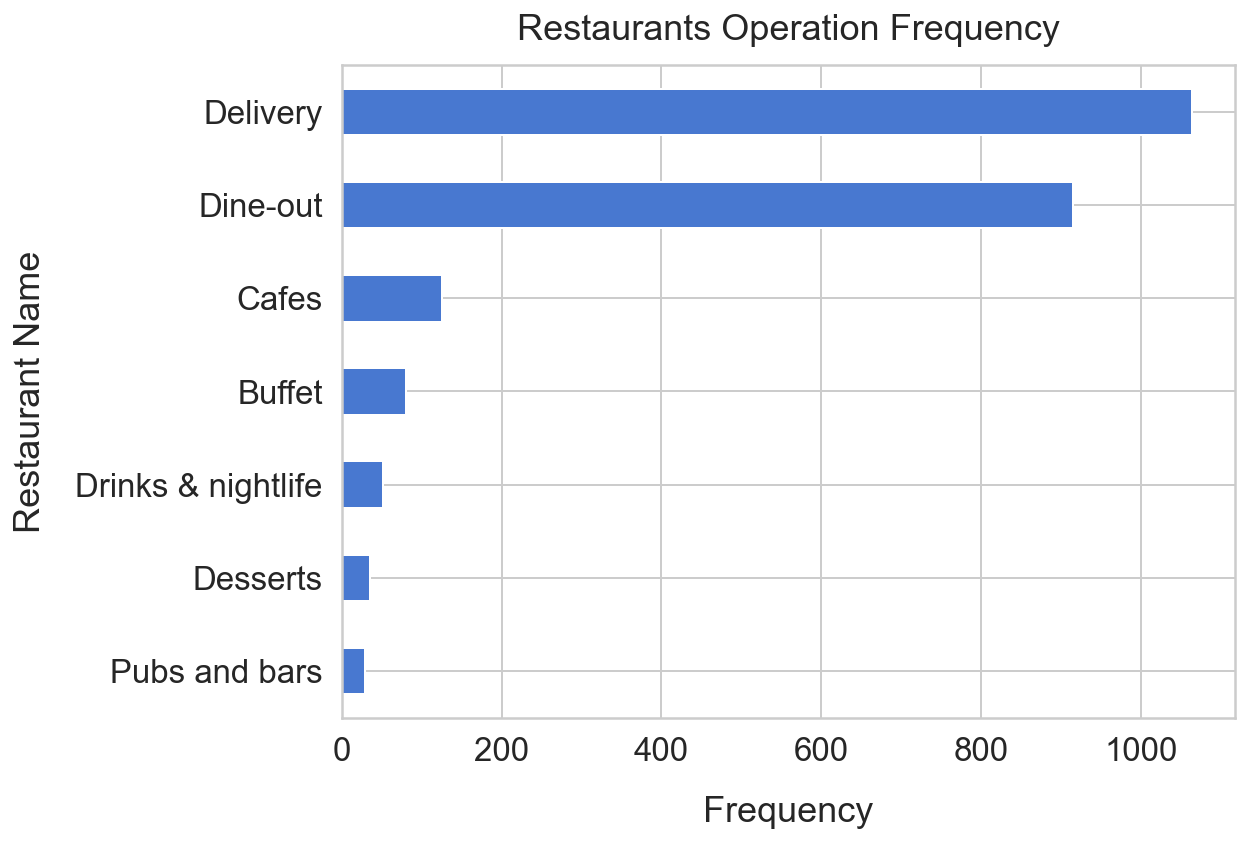

In [1582]:
df_top_frequenced_restaurants_types = df.groupby('restaurant_operation').agg({"table_bookings":'count'}).sort_values(by='table_bookings',ascending=False)
df_top_frequenced_restaurants_types.sort_values(by='table_bookings',ascending=True).plot(kind='barh',figsize=(8, 6))
plt.xlabel("Frequency", labelpad=14)
legend = plt.legend()
legend.remove()
plt.ylabel("Restaurant Name", labelpad=14)
plt.title("Restaurants Operation Frequency", y=1.02)

How does the distribution of Restaurants-opertation correlates with ratings ?

Text(0.5, 1.0, 'restaurant_operation Average Ratings')

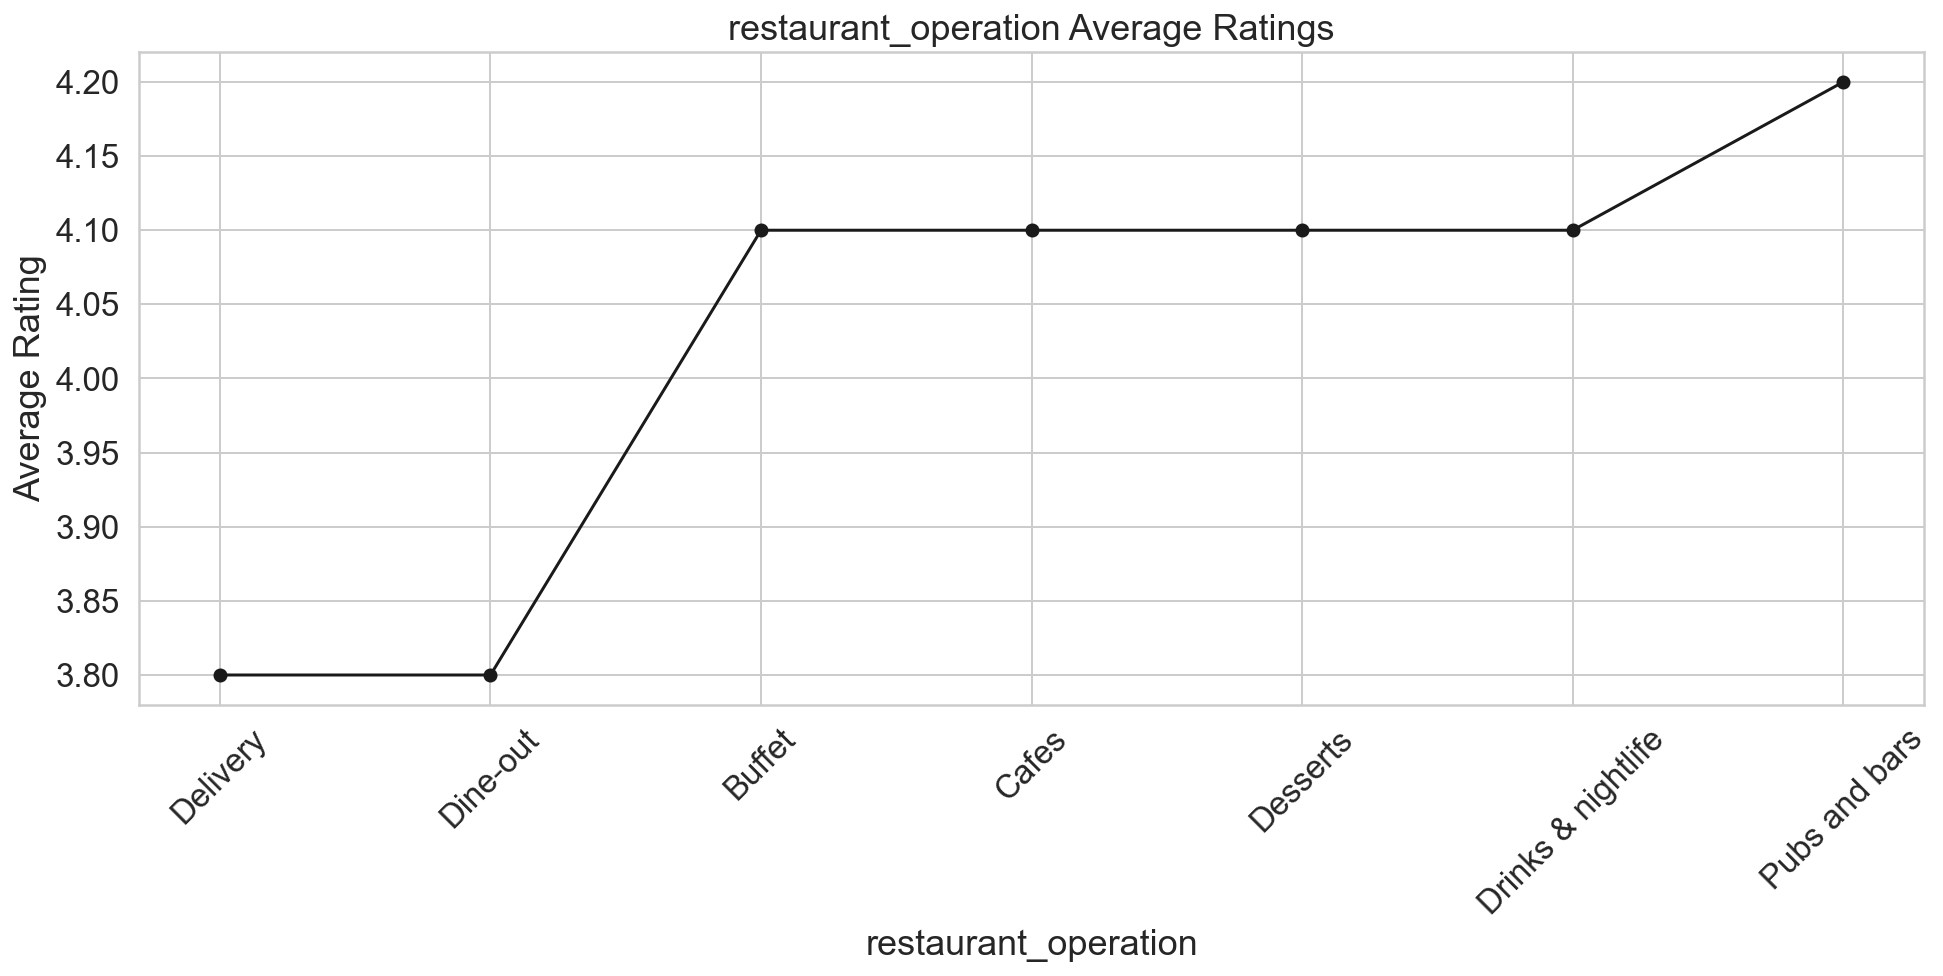

In [1585]:
location_average_ratings = df.groupby('restaurant_operation').agg({'rating':'median'}).sort_values(by='rating',ascending=True)
plt.plot(location_average_ratings.index,location_average_ratings['rating'],'ko-',label='rating')
plt.xticks(rotation=45)
plt.xlabel("restaurant_operation")
plt.ylabel("Average Rating")
plt.title("restaurant_operation Average Ratings")

Text(0.5, 1.0, 'Restaurant Operation Average Ratings')

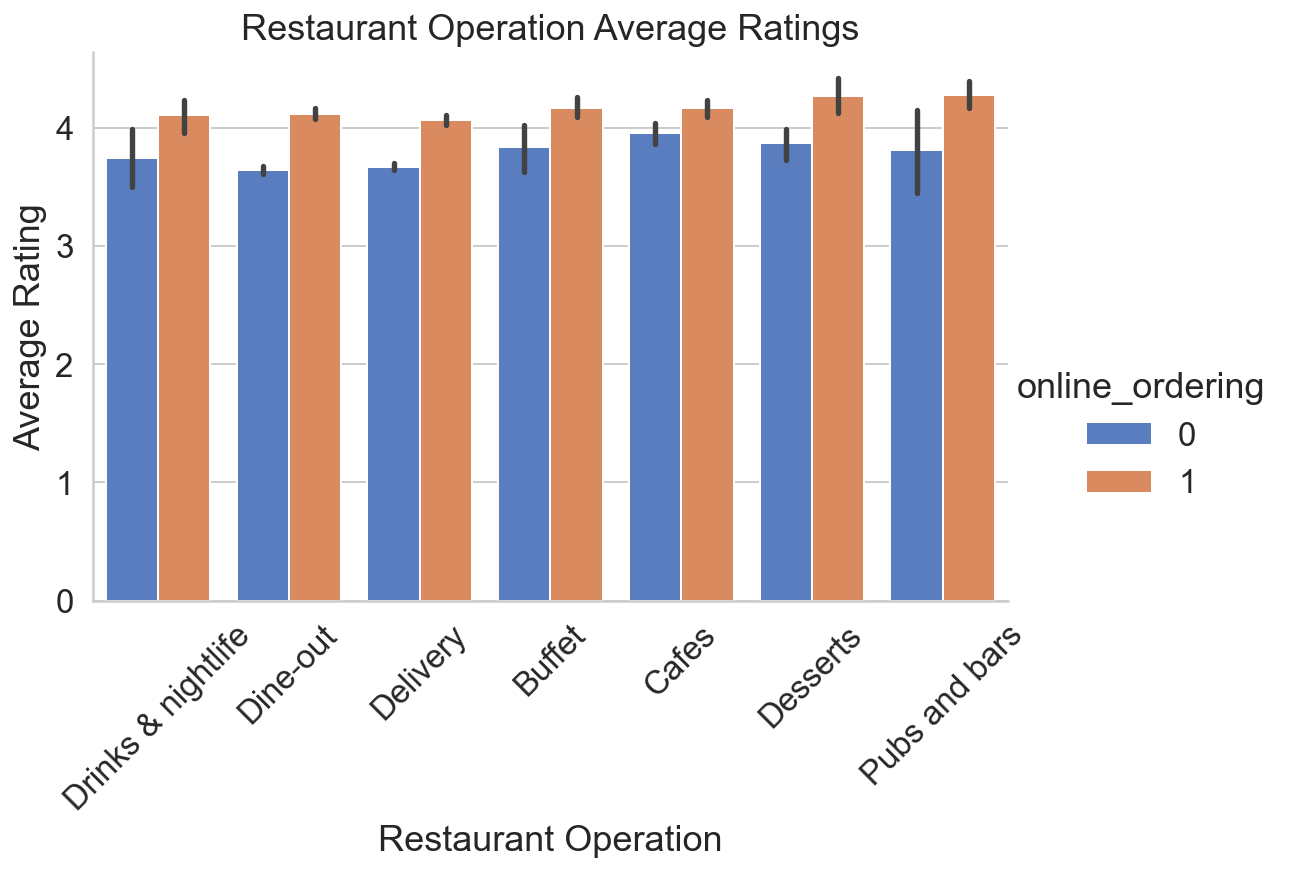

In [1632]:
df_barchart = pd.melt(df, id_vars=["restaurant_operation",'online_ordering'],value_vars='rating',value_name='rating')
sns.factorplot(x='restaurant_operation', y='rating', hue='online_ordering', data=df_barchart, kind='bar', aspect=1.5,estimator=np.mean)
plt.xticks(rotation=45)
plt.xlabel("Restaurant Operation")
plt.ylabel("Average Rating")
plt.title("Restaurant Operation Average Ratings")

Text(0.5, 1.0, 'Restaurant Operation Average Ratings')

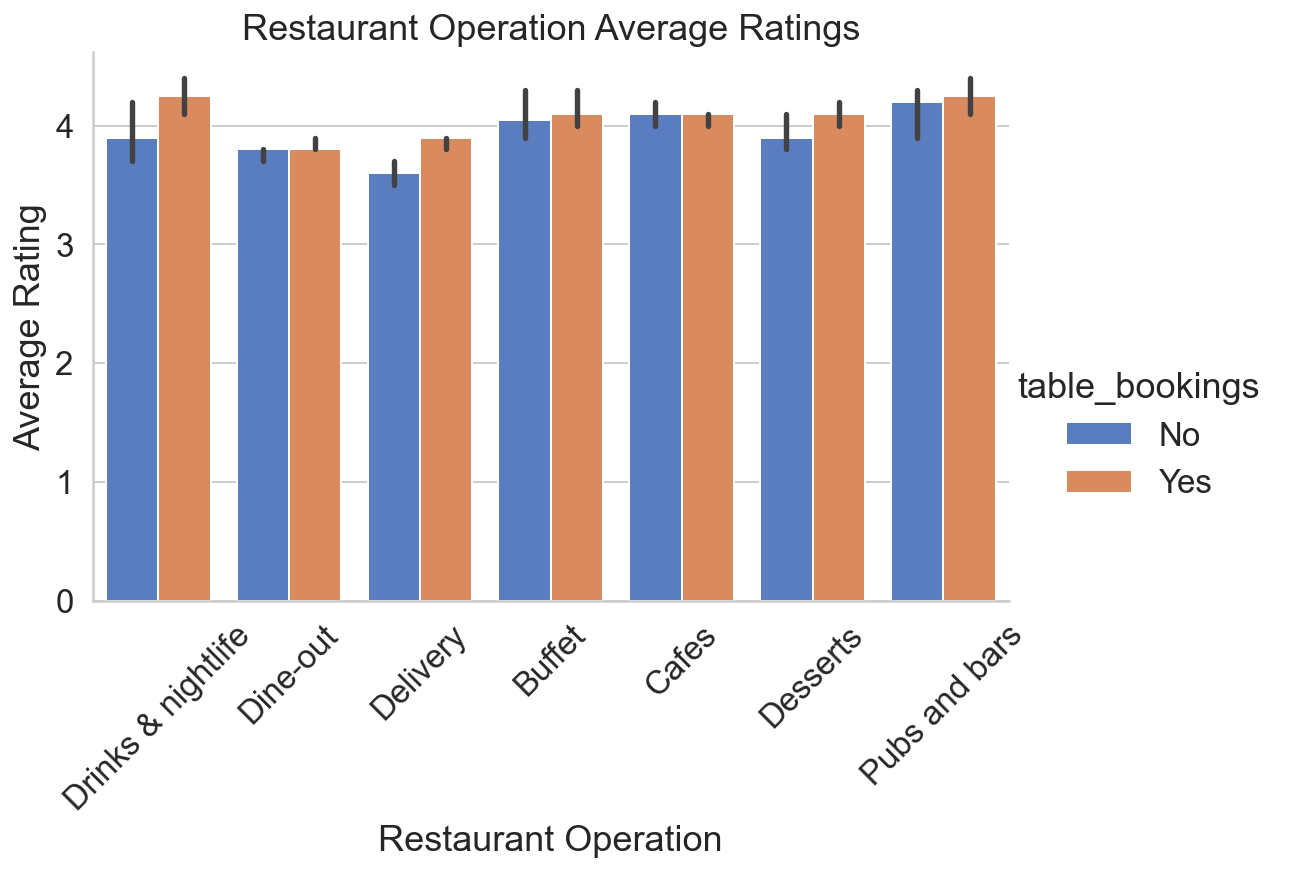

In [1584]:
df_barchart = pd.melt(df, id_vars=["restaurant_operation",'table_bookings'],value_vars='rating',value_name='rating')
sns.factorplot(x='restaurant_operation', y='rating', hue='table_bookings', data=df_barchart, kind='bar', aspect=1.5,estimator=np.median)
plt.xticks(rotation=45)
plt.xlabel("Restaurant Operation")
plt.ylabel("Average Rating")
plt.title("Restaurant Operation Average Ratings")

In [1610]:
numeric_columns = df.select_dtypes(include=['int64','float64']).columns

In [1611]:
corr = df[numeric_columns].corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

,rating,votes,popular_dishes,cuisines_offered
rating,1.00,0.47,0.64,0.29
votes,0.47,1.00,0.39,0.20
popular_dishes,0.64,0.39,1.00,0.32
cuisines_offered,0.29,0.20,0.32,1.00


# Data Processing

change the data type of online_ordering and table_booking to [1,0]

In [1612]:
df.loc[df["table_bookings"]=='Yes', 'table_bookings'] = 1
df.loc[df["table_bookings"]=='No', 'table_bookings'] = 0
df['table_bookings'] = df['table_bookings'].astype(int)

df.loc[df["online_ordering"]=='Yes', 'online_ordering'] = 1
df.loc[df["online_ordering"]=='No', 'online_ordering'] = 0
df['online_ordering'] = df['online_ordering'].astype(int)

### Splitting dataset to train and test

In [1613]:
# split data into train and test
X = df.drop(['rating'], axis=1)
y = df[['rating']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

df_train = pd.concat([X_train,y_train],axis=1)
df_test = pd.concat([X_test,y_test],axis=1)

### Cleaning

In [1614]:
numeric_columns = ['rating','votes','popular_dishes','cuisines_offered']
df_train[numeric_columns].describe()

,rating,votes,popular_dishes,cuisines_offered
count,1855.000000,1810.000000,1748.000000,1840.000000
mean,3.794663,649.387293,4.294622,2.723913
std,0.458538,1439.250458,2.795784,1.385026
min,2.100000,4.000000,1.000000,1.000000
25%,3.500000,35.000000,1.000000,2.000000
50%,3.900000,141.000000,5.000000,3.000000
75%,4.100000,665.250000,7.000000,4.000000
max,4.800000,14723.000000,7.000000,8.000000


<AxesSubplot:xlabel='votes'>

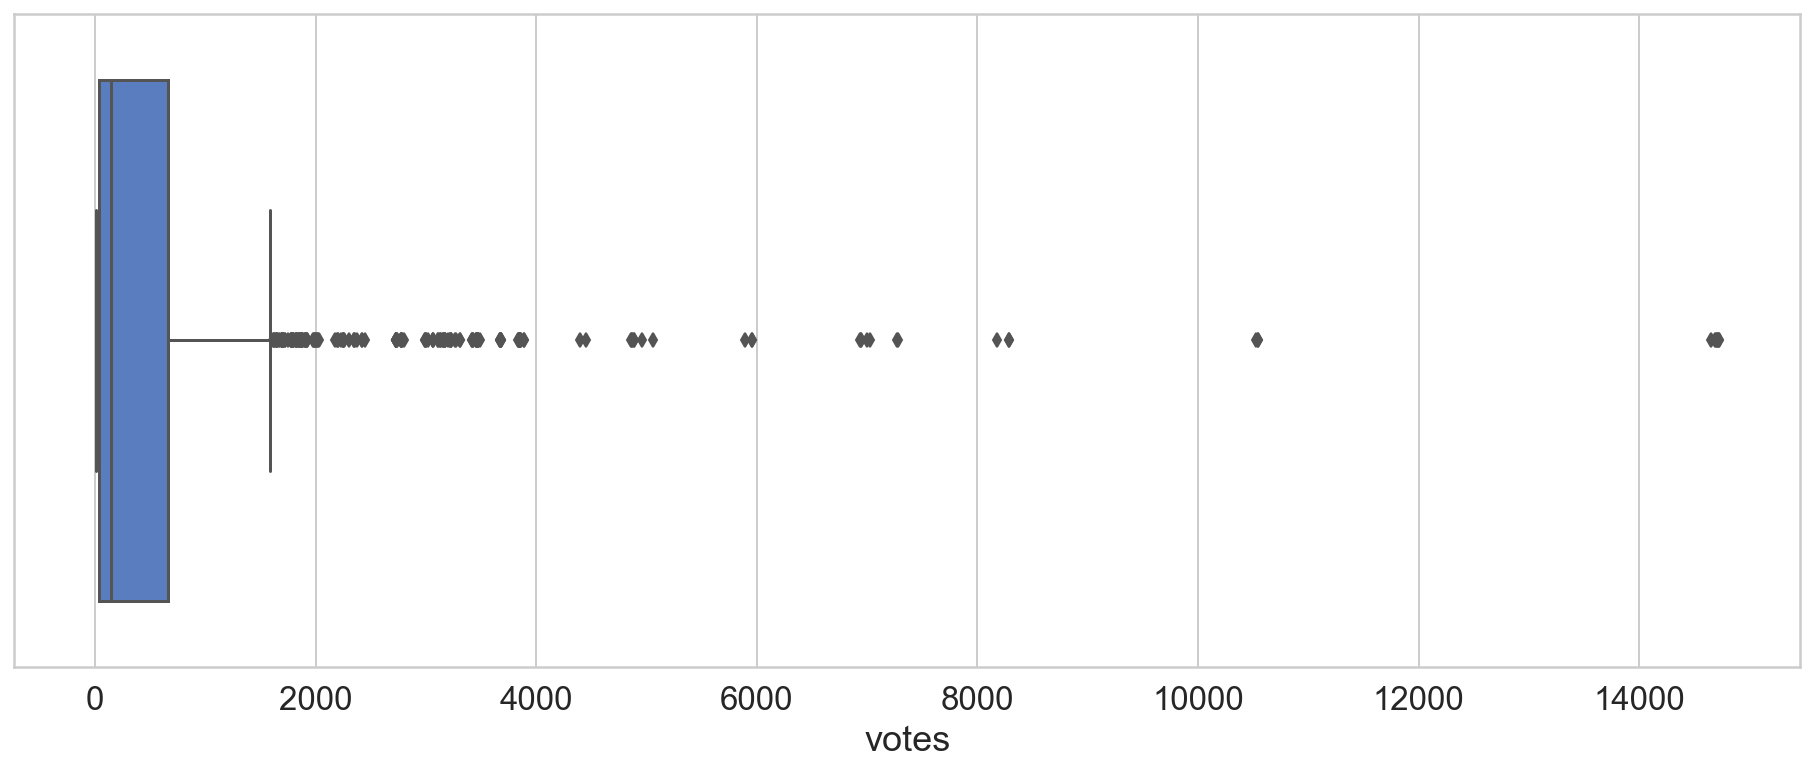

In [1615]:
sns.boxplot(df_train['votes'])

In [1505]:
df_train = df_train[df_train['votes'] <= 14000 ]

<AxesSubplot:xlabel='popular_dishes'>

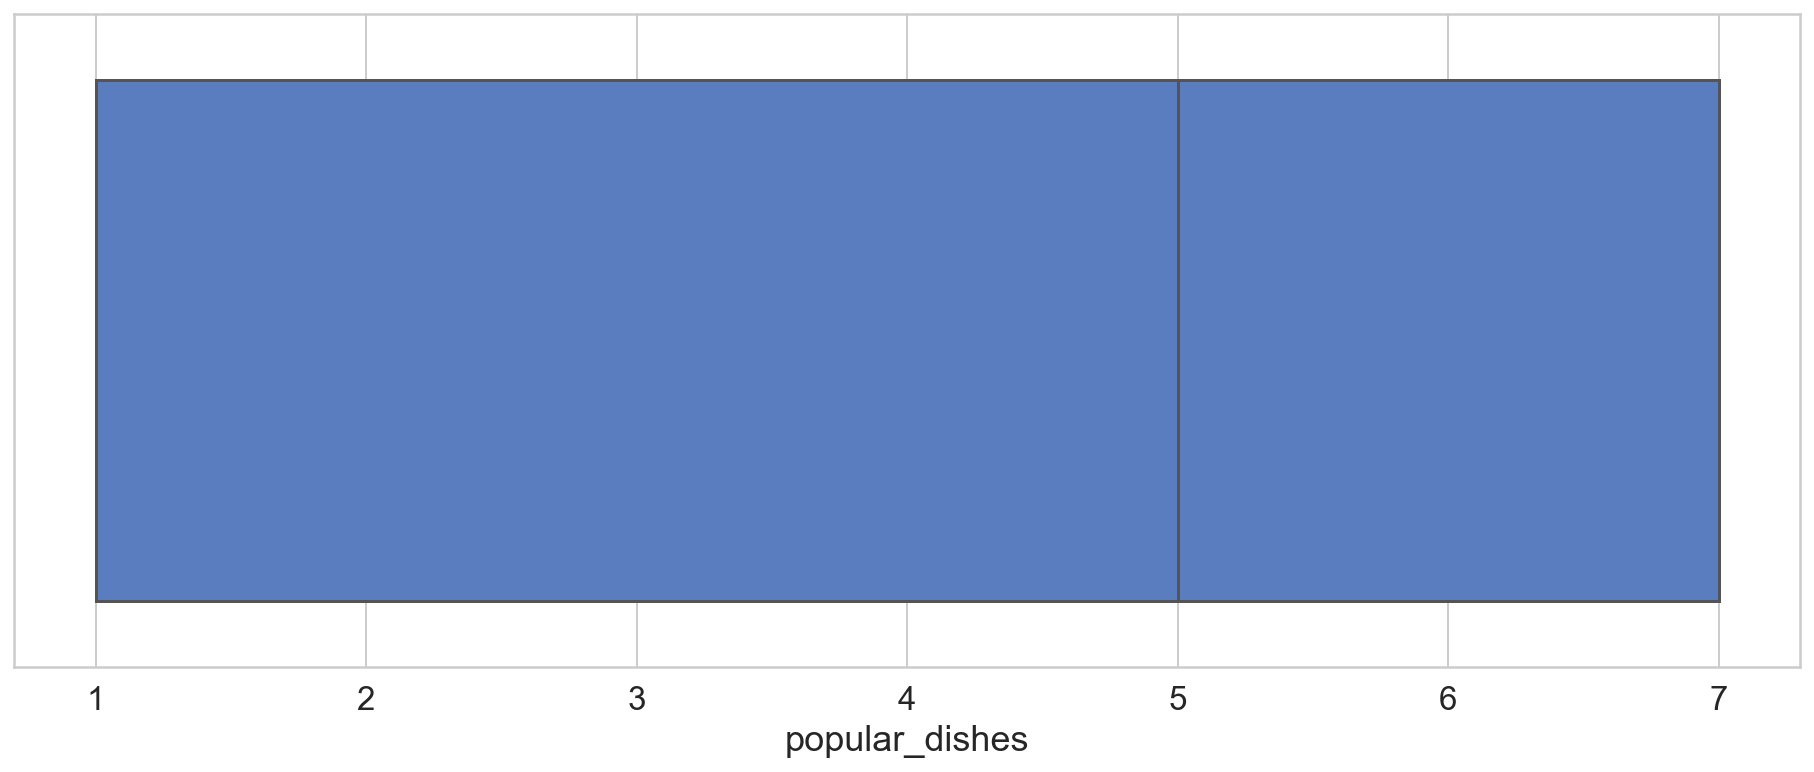

In [1616]:
sns.boxplot(df_train['popular_dishes'])

<AxesSubplot:xlabel='cuisines_offered'>

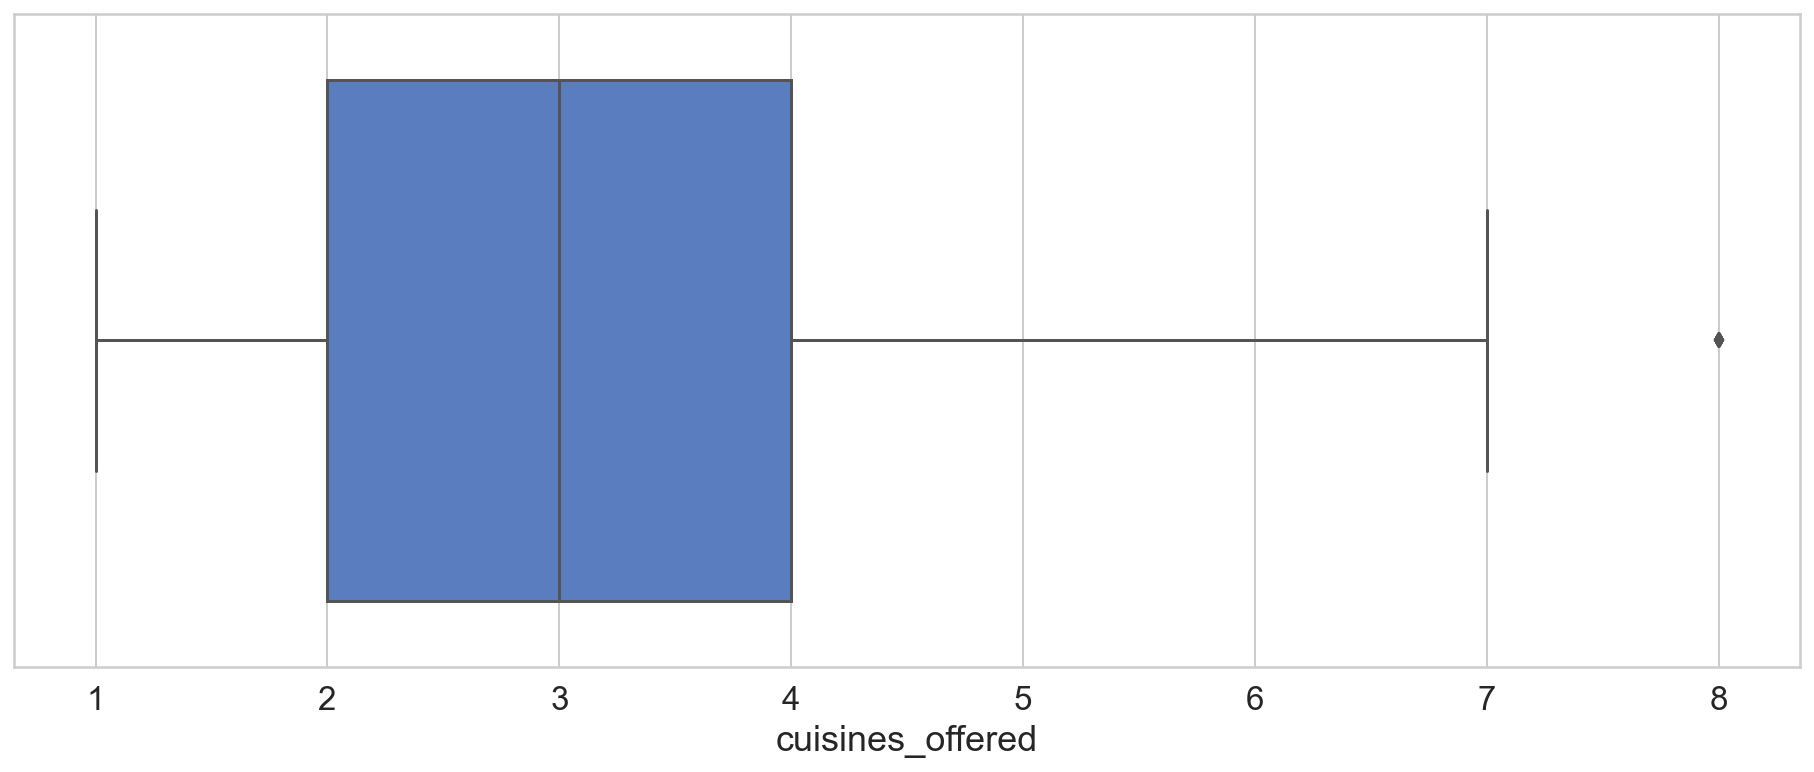

In [1617]:
sns.boxplot(df_train['cuisines_offered'])

### Filling missing values

Train Data

In [1506]:
df_train.isna().sum()

name                      0
table_bookings            0
online_ordering           0
location                  0
votes                     0
restaurant_type          86
restaurant_operation     14
popular_dishes          104
cuisines_offered         15
primary_cuisine          21
rating                    0
dtype: int64

In [1588]:
numeric_columns = ['rating','votes','popular_dishes','cuisines_offered']

Imputing numerical features with mean/median

In [1589]:
df_train[numeric_columns].describe()

,rating,votes,popular_dishes,cuisines_offered
count,1802.000000,1802.00000,1802.000000,1802.000000
mean,3.794617,587.00111,4.296820,2.725305
std,0.457280,1095.25298,2.714062,1.375810
min,2.100000,4.00000,1.000000,1.000000
25%,3.500000,35.00000,1.000000,2.000000
50%,3.900000,141.00000,5.000000,3.000000
75%,4.100000,631.75000,7.000000,4.000000
max,4.800000,10541.00000,7.000000,8.000000


In [1508]:
df_train['votes'].fillna(df_train['votes'].median(),inplace=True)
df_train['cuisines_offered'].fillna(df_train['cuisines_offered'].median(),inplace=True)
df_train['popular_dishes'].fillna(df_train['popular_dishes'].mean(),inplace=True)

Imputing categorical features with most frequent value

In [1509]:
df_train['restaurant_type'].fillna(df_train['restaurant_type'].value_counts().index[0],inplace=True)
df_train['restaurant_operation'].fillna(df_train['restaurant_operation'].value_counts().index[0],inplace=True)
df_train['primary_cuisine'].fillna(df_train['primary_cuisine'].value_counts().index[0],inplace=True)

In [1510]:
df_train.isna().sum()

name                    0
table_bookings          0
online_ordering         0
location                0
votes                   0
restaurant_type         0
restaurant_operation    0
popular_dishes          0
cuisines_offered        0
primary_cuisine         0
rating                  0
dtype: int64

Test Data

In [1511]:
df_test.isna().sum()

name                     0
table_bookings           0
online_ordering          0
location                 0
votes                   10
restaurant_type         23
restaurant_operation     6
popular_dishes          31
cuisines_offered         4
primary_cuisine          5
rating                   0
dtype: int64

Imputing numerical features with mean/median

In [1618]:
df_test[numeric_columns].describe()

,rating,votes,popular_dishes,cuisines_offered
count,464.000000,454.000000,433.000000,460.000000
mean,3.814655,627.198238,4.436490,2.669565
std,0.428116,1509.723389,2.753156,1.403213
min,2.600000,4.000000,1.000000,1.000000
25%,3.500000,42.250000,1.000000,2.000000
50%,3.900000,153.500000,6.000000,2.000000
75%,4.100000,577.750000,7.000000,4.000000
max,4.800000,14710.000000,7.000000,8.000000


In [1513]:
df_test['votes'].fillna(df_test['votes'].median(),inplace=True)
df_test['cuisines_offered'].fillna(df_test['cuisines_offered'].median(),inplace=True)
df_test['popular_dishes'].fillna(df_test['popular_dishes'].mean(),inplace=True)

Imputing categorical features with most frequent value

In [1514]:
df_test['restaurant_type'].fillna(df_test['restaurant_type'].value_counts().index[0],inplace=True)
df_test['restaurant_operation'].fillna(df_test['restaurant_operation'].value_counts().index[0],inplace=True)
df_test['primary_cuisine'].fillna(df_test['primary_cuisine'].value_counts().index[0],inplace=True)

In [1515]:
df_test.isna().sum()

name                    0
table_bookings          0
online_ordering         0
location                0
votes                   0
restaurant_type         0
restaurant_operation    0
popular_dishes          0
cuisines_offered        0
primary_cuisine         0
rating                  0
dtype: int64

# Feature Engineering

generate feature for location frequency

onehot encoding

In [1517]:
df_train = df_train.drop(columns=['name']).reset_index(drop=True)
df_test = df_test.drop(columns=['name']).reset_index(drop=True)

df_train_numeric = df_train.select_dtypes(include=['int32','float64'])
df_test_numeric = df_test.select_dtypes(include=['int32','float64'])

ohenc = OneHotEncoder(sparse=False)

ohenc.fit(df_train.select_dtypes(
    include=['object', 'category']))

df_train_onehot = pd.DataFrame(ohenc.fit_transform(df_train.select_dtypes(
    include=['object', 'category'])))

df_test_onehot = pd.DataFrame(ohenc.fit_transform(df_test.select_dtypes(
    include=['object', 'category'])))

features_names = ohenc.get_feature_names(df_train.select_dtypes(
    include=['object', 'category']).columns.tolist())

df_train_onehot.columns = features_names
df_test_onehot.columns = features_names

df_train = pd.concat([df_train_numeric, df_train_onehot], axis=1)
df_test = pd.concat([df_test_numeric, df_test_onehot], axis=1)

Correlation

In [1590]:
corr = df_train[numeric_columns].corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

,rating,votes,popular_dishes,cuisines_offered
rating,1.00,0.51,0.63,0.30
votes,0.51,1.00,0.46,0.22
popular_dishes,0.63,0.46,1.00,0.32
cuisines_offered,0.30,0.22,0.32,1.00


### Scaling

In [1520]:
X_transformer = MinMaxScaler(feature_range=(0, 1))
X_transformer.fit(df_train.drop(columns=['rating']))

y_transformer = MinMaxScaler(feature_range=(0, 1))
y_transformer.fit(np.array(df_train['rating']).reshape(-1, 1))

X_train = pd.DataFrame(X_transformer.transform(df_train.drop(columns=['rating']) )
                                   ,columns=df_train.drop(columns=['rating']).columns.tolist())
y_train = y_transformer.transform(np.array(df_train['rating']).reshape(-1, 1))

X_test = pd.DataFrame(X_transformer.transform(df_test.drop(columns=['rating']))
                                  ,columns=df_test.drop(columns=['rating']).columns.tolist())
y_test = y_transformer.transform(np.array(df_test[['rating']]).reshape(-1, 1))

Feature Selection

Text(0.5, 0, 'Feature Importance')

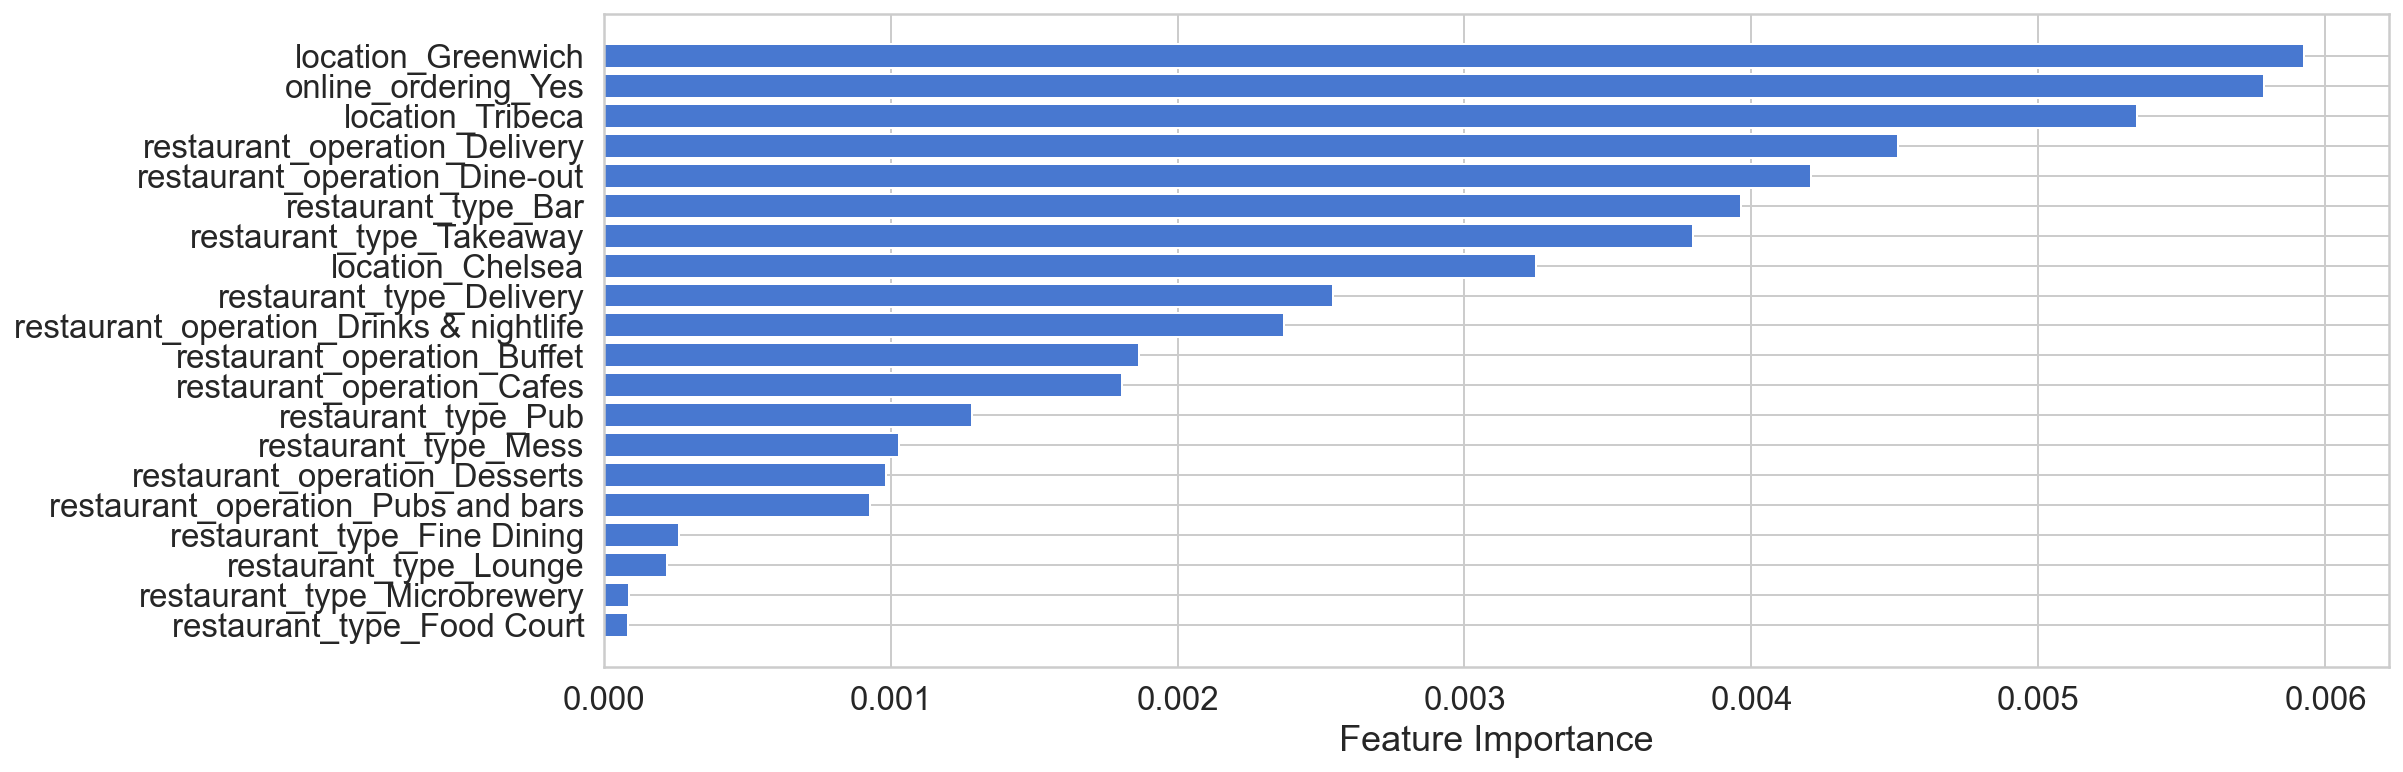

In [1542]:
model = RandomForestRegressor(n_estimators=50)
model.fit(X_train, y_train)
sort = model.feature_importances_.argsort()
plt.barh(X_train.columns[sort][0:20], model.feature_importances_[sort][0:20])
plt.xlabel("Feature Importance")

# Modeling

In [1543]:
# evaluation dataframe
evaluation = pd.DataFrame(columns=['name','dataset type','rmse', 'mse', 'r2'])

### Linear Regression

Training

In [1575]:
model_name = 'linear regression'

In [1545]:
reg = LinearRegression()
reg.fit(X_train, y_train)

LinearRegression()

Evaluation

In [1546]:
result = model_evaluate(model_name,'train',reg,y_transformer,X_train,y_train)
evaluation.loc[len(evaluation)] = result
result = model_evaluate(model_name,'test',reg,y_transformer,X_test,y_test)
evaluation.loc[len(evaluation)] = result

Grid Search

In [1574]:
reg=LinearRegression()

param_grid = { 
    'fit_intercept' :  [True, False],
    'normalize' :[True, False],
}

CV = GridSearchCV(estimator=reg, param_grid=param_grid, cv= 3,scoring='neg_root_mean_squared_error')
CV.fit(X_train, y_train)
CV.best_params_

{'fit_intercept': False, 'normalize': True}

In [1576]:
result = model_evaluate(model_name+'Grid','train',CV,y_transformer,X_train,y_train)
evaluation.loc[len(evaluation)] = result
result = model_evaluate(model_name+'Grid','test',CV,y_transformer,X_test,y_test)
evaluation.loc[len(evaluation)] = result

PCA

In [1549]:
n_comp = 10
pca = PCA(n_components=n_comp)
rand = LinearRegression()

X_train_transformed = pca.fit_transform(X_train)
X_test_transformed = pca.transform(X_test)

rand.fit(X_train_transformed, y_train)


LinearRegression()

In [1550]:
result = model_evaluate(model_name+'PCA='+str(n_comp),'train',rand,y_transformer,X_train_transformed,y_train)
evaluation.loc[len(evaluation)] = result
result = model_evaluate(model_name+'PCA='+str(n_comp),'test',rand,y_transformer,X_test_transformed,y_test)
evaluation.loc[len(evaluation)] = result

Text(0.5, 1.0, 'RMSE by Model')

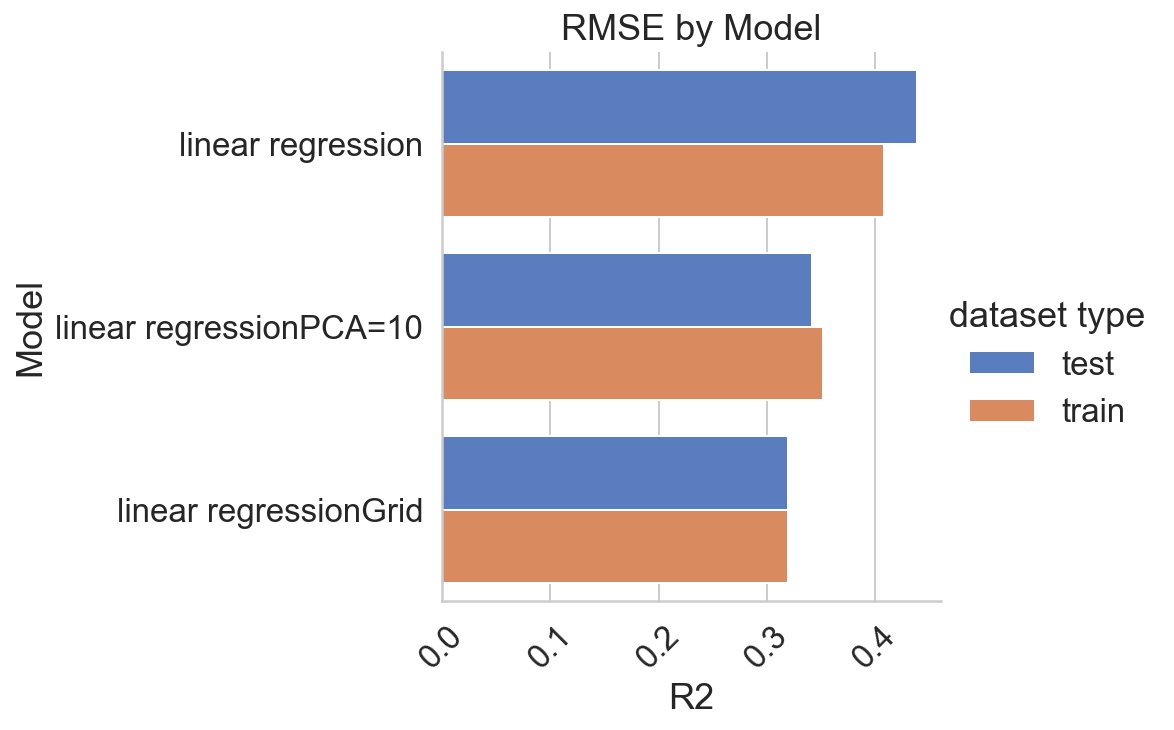

In [1551]:
models_list = evaluation[evaluation['name'].str.contains(model_name)]
df_barchart = pd.melt(models_list, id_vars=["name",'dataset type'],value_vars='rmse',value_name='rmse').sort_values(by='rmse', ascending=False)
sns.factorplot(y='name', x='rmse', hue='dataset type', data=df_barchart, kind='bar', aspect=1.5,estimator=np.median)
plt.xticks(rotation=45)
plt.ylabel("Model")
plt.xlabel("RMSE")
plt.title("RMSE by Model")

### Random Forest Regressor

In [1552]:
model_name = 'Random Forest'

Training

In [1553]:
rand = RandomForestRegressor()
rand.fit(X_train, y_train)

RandomForestRegressor()

Evaluation

In [1554]:
result = model_evaluate(model_name,'train',rand,y_transformer,X_train,y_train)
evaluation.loc[len(evaluation)] = result
result = model_evaluate(model_name,'test',rand,y_transformer,X_test,y_test)
evaluation.loc[len(evaluation)] = result

grid search

In [1555]:
rand=RandomForestRegressor()

param_grid = { 
    'n_estimators': range(50,100,10),
    'max_depth' : range(5,10,1),
    'max_features' : range(2,15,1),
    'min_samples_split' : range(10,30,5),
}

CV = GridSearchCV(estimator=rand, param_grid=param_grid, cv= 3,scoring='neg_root_mean_squared_error')
CV.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=RandomForestRegressor(),
             param_grid={'max_depth': range(5, 10),
                         'max_features': range(2, 15),
                         'min_samples_split': range(10, 30, 5),
                         'n_estimators': range(50, 100, 10)},
             scoring='neg_root_mean_squared_error')

In [1556]:
CV.best_params_

{'max_depth': 9,
 'max_features': 13,
 'min_samples_split': 10,
 'n_estimators': 80}

In [1557]:
result = model_evaluate(model_name+'Grid','train',CV,y_transformer,X_train,y_train)
evaluation.loc[len(evaluation)] = result
result = model_evaluate(model_name+'Grid','test',CV,y_transformer,X_test,y_test)
evaluation.loc[len(evaluation)] = result

PCA

In [1558]:
n_comp = 5
pca = PCA(n_components=n_comp)
rand = RandomForestRegressor(
    n_estimators=70, max_depth=9, min_samples_split=10)

X_train_transformed = pca.fit_transform(X_train)
X_test_transformed = pca.transform(X_test)

rand.fit(X_train_transformed, y_train)


RandomForestRegressor(max_depth=9, min_samples_split=10, n_estimators=70)

In [1559]:
result = model_evaluate(model_name+'PCA='+str(n_comp),'train',rand,y_transformer,X_train_transformed,y_train)
evaluation.loc[len(evaluation)] = result
result = model_evaluate(model_name+'PCA='+str(n_comp),'test',rand,y_transformer,X_test_transformed,y_test)
evaluation.loc[len(evaluation)] = result

Text(0.5, 1.0, 'RMSE by Model')

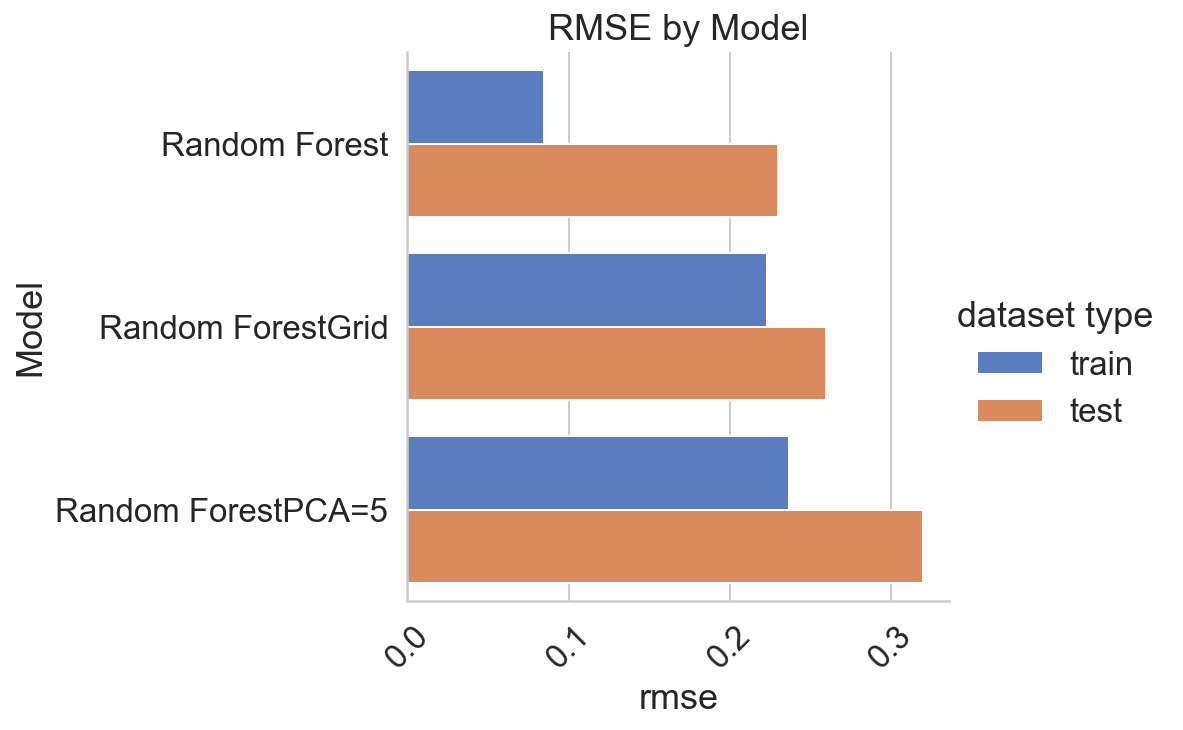

In [1560]:
models_list = evaluation[evaluation['name'].str.contains(model_name)]
df_barchart = pd.melt(models_list, id_vars=["name",'dataset type'],value_vars='rmse',value_name='rmse').sort_values(by='rmse', ascending=True)
sns.factorplot(y='name', x='rmse', hue='dataset type', data=df_barchart, kind='bar', aspect=1.5,estimator=np.mean)
plt.xticks(rotation=45)
plt.ylabel("Model")
plt.xlabel("rmse")
plt.title("RMSE by Model")

### Decision Tree

In [1620]:
model_name = 'Decision Tree'

In [1564]:
dt = DecisionTreeRegressor()
dt.fit(X_train, y_train)

DecisionTreeRegressor()

In [1565]:
result = model_evaluate(model_name,'train',dt,y_transformer,X_train,y_train)
evaluation.loc[len(evaluation)] = result
result = model_evaluate(model_name,'test',dt,y_transformer,X_test,y_test)
evaluation.loc[len(evaluation)] = result

Tuning

In [1567]:
dt=DecisionTreeRegressor()

param_grid = { 
    'max_depth' : range(5,15,1),
    'min_samples_split' : range(10,20,1),
    'max_features' : range(5,30,5),
}

CV = GridSearchCV(estimator=dt, param_grid=param_grid, cv= 5)
CV.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeRegressor(),
             param_grid={'max_depth': range(5, 15),
                         'max_features': range(5, 30, 5),
                         'min_samples_split': range(10, 20)})

In [1568]:
result = model_evaluate(model_name+'+Grid','train',CV,y_transformer,X_train,y_train)
evaluation.loc[len(evaluation)] = result
result = model_evaluate(model_name+'+Grid','test',CV,y_transformer,X_test,y_test)
evaluation.loc[len(evaluation)] = result

Evaluation

Text(0.5, 1.0, 'RMSE by Model')

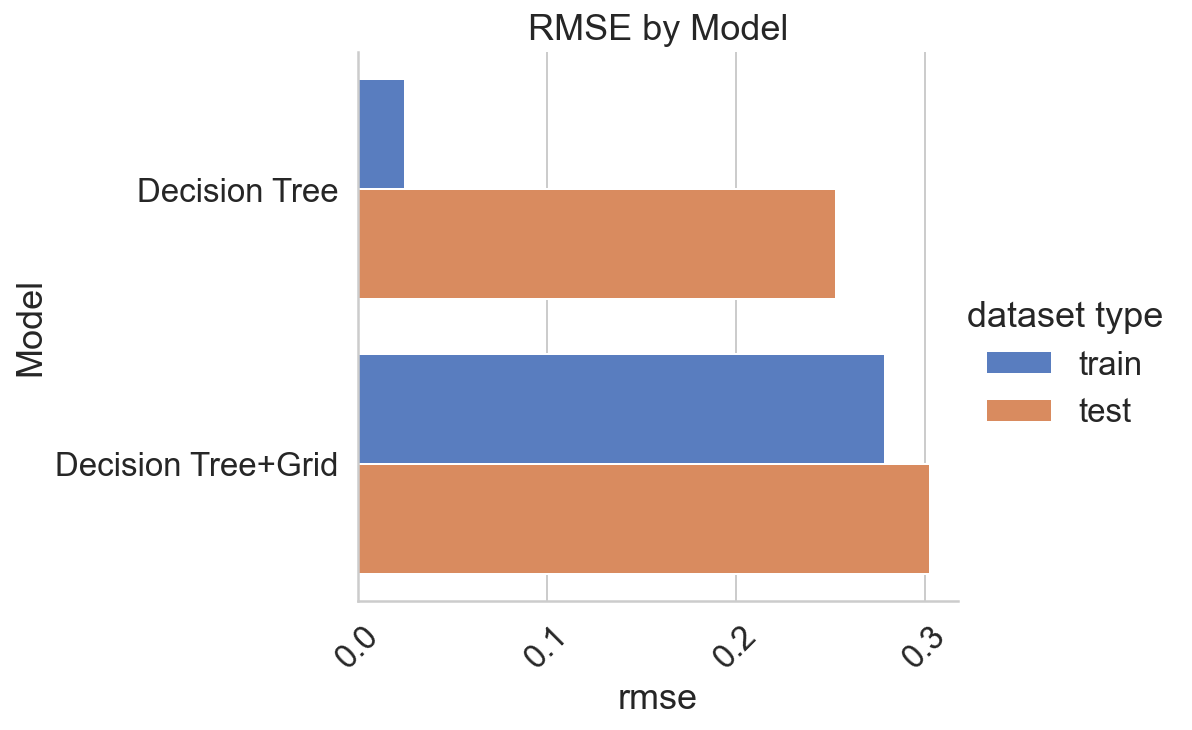

In [1621]:
models_list = evaluation[evaluation['name'].str.contains(model_name)]
df_barchart = pd.melt(models_list, id_vars=["name",'dataset type'],value_vars='rmse',value_name='rmse').sort_values(by='rmse', ascending=True)
sns.factorplot(y='name', x='rmse', hue='dataset type', data=df_barchart, kind='bar', aspect=1.5,estimator=np.median)
plt.xticks(rotation=45)
plt.ylabel("Model")
plt.xlabel("rmse")
plt.title("RMSE by Model")

### Model Selection

Text(0.5, 1.0, 'rmse by Model')

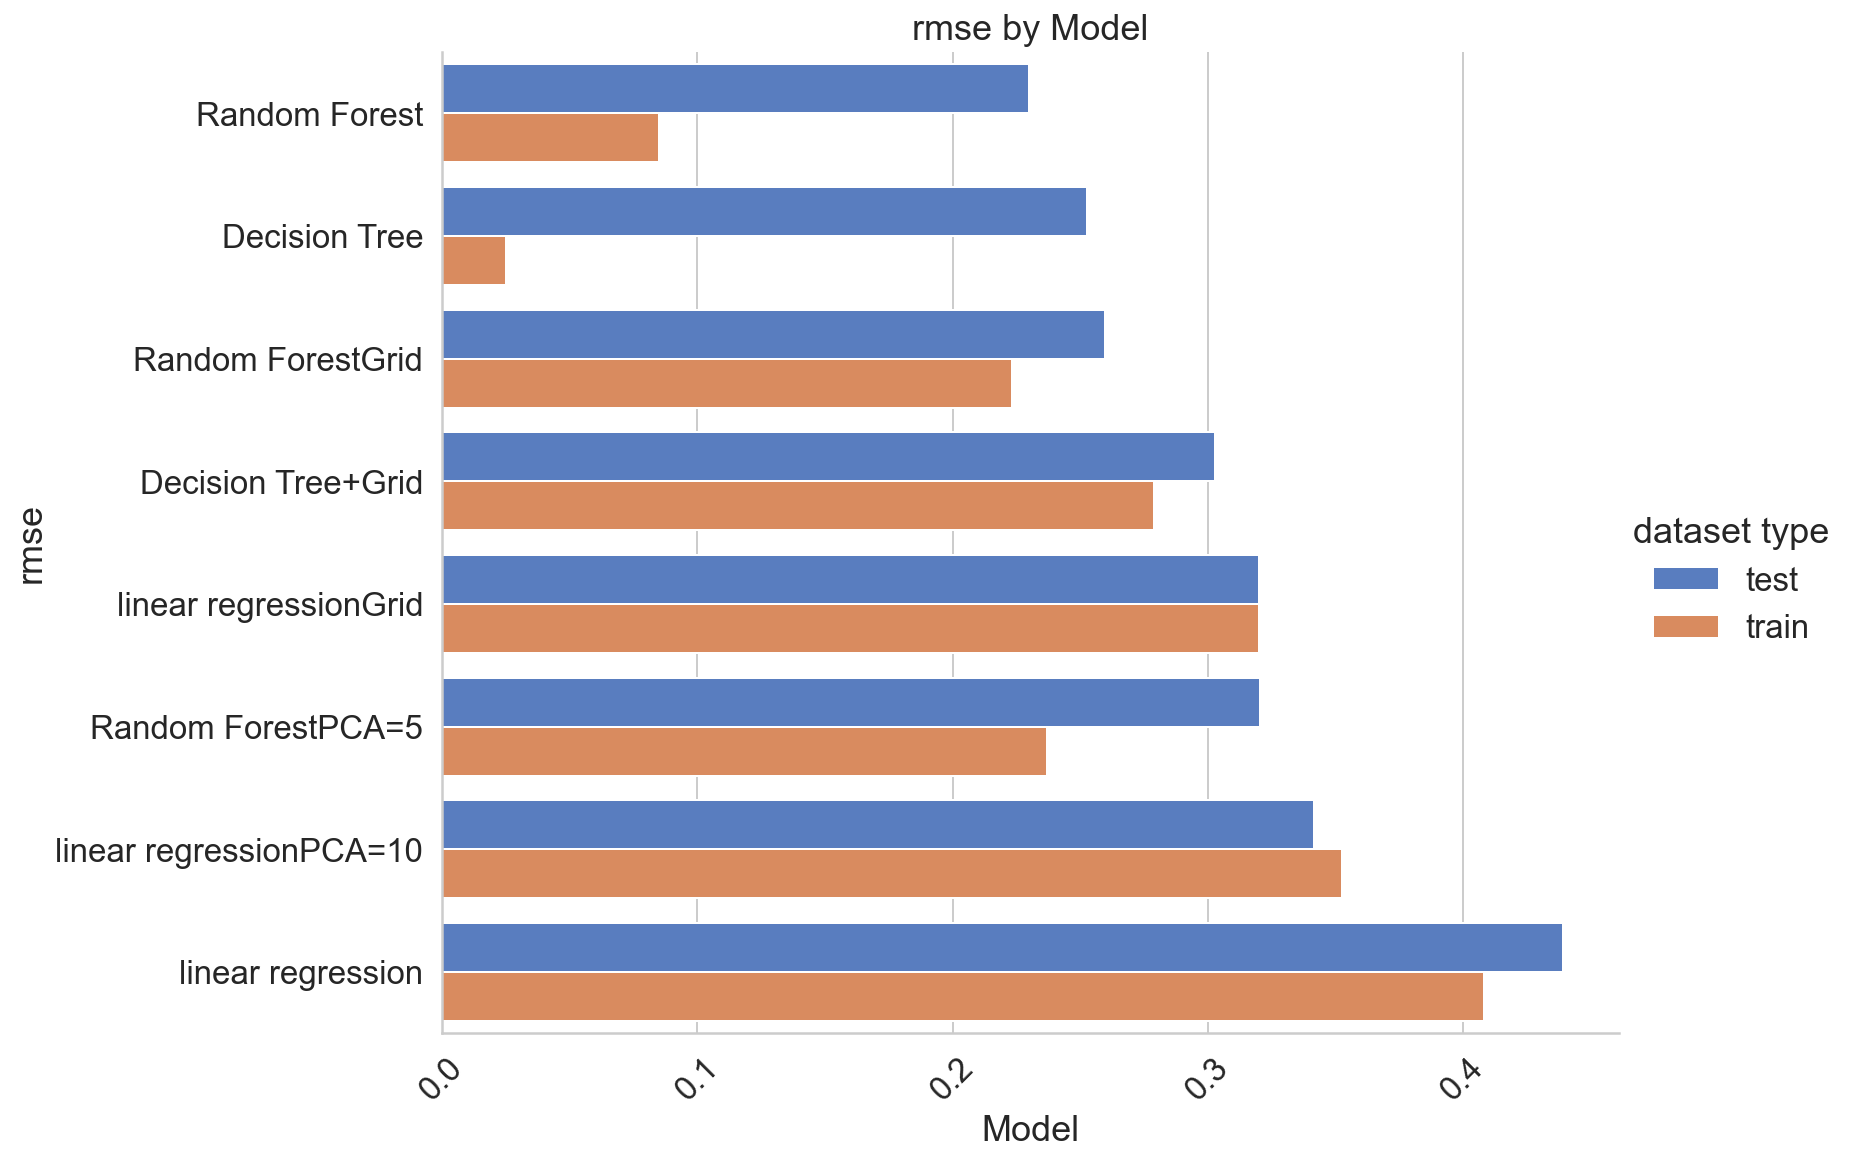

In [1577]:
df_barchart = pd.melt(evaluation, id_vars=["name",'dataset type'],value_vars='rmse',value_name='rmse').sort_values(by=['dataset type','rmse'], ascending=[True,True])
sns.factorplot(y='name', x='rmse', hue='dataset type', data=df_barchart, kind='bar', aspect=1.5,estimator=np.median,size=8)
plt.xticks(rotation=45)
plt.xlabel("Model")
plt.ylabel("rmse")
plt.title("rmse by Model")

Best Model:

Random Forest Regressor with 0.229 RMSE, 0.7109 R2



Recommendations :

- Add online ordering and table booking features to your restaurant would increase your ratings
- having more popular cuisines would increase your ratings